# Term Deposit Marketing

For this project, we are working with a call center company, to look for ways to improve the success rate of their calls made to customers. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our client to make informed decisions. The company we are working with sells term-deposit subscriptions over the phone.

Our machine learning product consists of three sections. The first section is a 'Customer Model', which takes as inputs features that are related to customers. Here, we attempt to create a classification model that can predict whether a customer is likely to subscribe to our product. By analysing this model, we are able to identify the customer features that are most indicative of whether a customer will subscribe to the product or not. The main goal of this model is to cut down on the unnecessary calls made to customers who are unlikely to subscribe. By doing this, we save the company significant costs related to these unnecessary calls. 

The second section is a 'call model', which takes as inputs all our features related to the customer and number of calls made to them. Here, we attempt to create a classification model that accurately predicts whether a customer will subscribe to the product or not. By analysing this model, we are able to to identify which features are indiciative of whether a customer will subscribe to the product or not. Thus, we can make recommendations to our calling staff, suggesting ways to improve their likelihood of making a sale to their customers. 

The third and final part consists of an unsupervised machine learning model for our subscribers base. Here, we attempt to understand the main groups in our subscriber base, in order to make recommendations to our callers for which general demographics to target. This section can be seen as an extension/accompinement to our Customers Model.

In [184]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    make_scorer, precision_score, recall_score, roc_auc_score, f1_score, accuracy_score, classification_report,
    roc_curve, auc, precision_recall_curve, confusion_matrix)
from scipy.stats.distributions import loguniform
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from lazypredict.Supervised import LazyClassifier

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline  # combining classifier steps
from sklearn.preprocessing import StandardScaler # scaling features

import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, make_scorer, precision_score
from hyperopt import space_eval
from sklearn.tree import export_text
from sklearn import set_config

from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
import pandas as pd
import random

from sklearn.neighbors import NearestCentroid
import lightgbm as lgb
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from matplotlib.patches import Patch


In [2]:
#ROC curve drawing by using the helper function
def plot_roc_curve(roc):
    """
    Plots the ROC curve from a DataFrame.
    
    Parameters:
    - roc: DataFrame containing 'false positive rate', 'true positive rate', and 'threshold' columns.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(roc['false positive rate'], roc['true positive rate'], label='ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # adding a 45-degree dashed line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [3]:
def pretty_confusion_matrix(confmat, labels, title, labeling=False, highlight_indexes=[]):
    '''
    Plots the confusion matrix, given relevant data.
    '''
    labels_list = [["TN", "FP"], ["FN", "TP"]]
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            if labeling:
                label = str(confmat[i, j])+" ("+labels_list[i][j]+")"
            else:
                label = confmat[i, j]
            
            
            if [i,j] in highlight_indexes:
                ax.text(x=j, y=i, s=label, va='center', ha='center',
                        weight = "bold", fontsize=18, color='#32618b')
            else:
                ax.text(x=j, y=i, s=label, va='center', ha='center')
       
    # change the labels
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax.set_xticklabels(['']+[labels[0], labels[1]])
        ax.set_yticklabels(['']+[labels[0], labels[1]])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_label_position('top')
    plt.suptitle(title)
    plt.tight_layout()
    
    plt.show()

In [190]:
def plot_coefs(all_coeffs, order, title):
    '''
    Function for plotting a barplot of the coefficients of the fitted model.
    Will be used in logistic regression model.
    '''
    # setting colors for positive and negative coefficients.
    colors = ['red' if value > 0 else 'blue' for value in all_coeffs]
    
    plt.bar(range(len(all_coeffs)),all_coeffs, align='center', color=colors)
    plt.xticks(range(len(order)), order, size='small',rotation = 70)
    plt.tight_layout
    # Create custom legend entries
    legend_handles = [
        Patch(color='red', label='Positive'),
        Patch(color='blue', label='Negative')
    ]
    
    plt.legend(handles=legend_handles)
    
    # Set labels and title
    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.title(title)
    plt.show()

In [5]:
def plot_feature_importance(model, names, threshold = None):
    feature_importance_df = pd.DataFrame.from_dict({'feature_importance': model.feature_importances_[:len(names)],
                                                    'feature': names})\
            .set_index('feature').sort_values('feature_importance', ascending = False)

    if threshold is not None:
        feature_importance_df = feature_importance_df[feature_importance_df.feature_importance > threshold]

    feature_importance_df.plot(kind="barh")
    plt.show()



In [6]:
df = pd.read_csv("term-deposit-marketing-2020.csv")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


##### Data Attributes

The attributes in our dataset are shown below

age : age of customer (numeric)

job : type of job (categorical)

marital : marital status (categorical)

education (categorical)

default: has credit in default? (binary)

balance: average yearly balance, in euros (numeric)

housing: has a housing loan? (binary)

loan: has personal loan? (binary)

contact: contact communication type (categorical)

day: last contact day of the month (numeric)

month: last contact month of year (categorical)

duration: last contact duration, in seconds (numeric)

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

y : our target variable, whether individual has subscribed or not (binary)


#### Comments

- No nulls, which is good
- A substantial number of categorical variables, which will expand our feature space when one-hot encoded
- Some binary variables
- Some numeric variables as well


In [8]:
df.describe()

,age,balance,day,duration,campaign
count,40000.00,40000.00,40000.00,40000.00,40000.00
mean,40.54,1274.28,16.02,254.82,2.88
std,9.64,2903.77,8.28,259.37,3.24
min,19.00,-8019.00,1.00,0.00,1.00
25%,33.00,54.00,8.00,100.00,1.00
50%,39.00,407.00,17.00,175.00,2.00
75%,48.00,1319.00,21.00,313.00,3.00
max,95.00,102127.00,31.00,4918.00,63.00


#### Numeric Attributes Analyis

Distributions are shown below. As we can see, the variables have a range of distributions. 
- Age is fairly evenly distributed, slightly skewed to the left
- Balance is strongly skewed to the left
- day is fairly evenly distributed around days of the month
- duration strongly skewed to the left
- campaign strongly skewed to the left


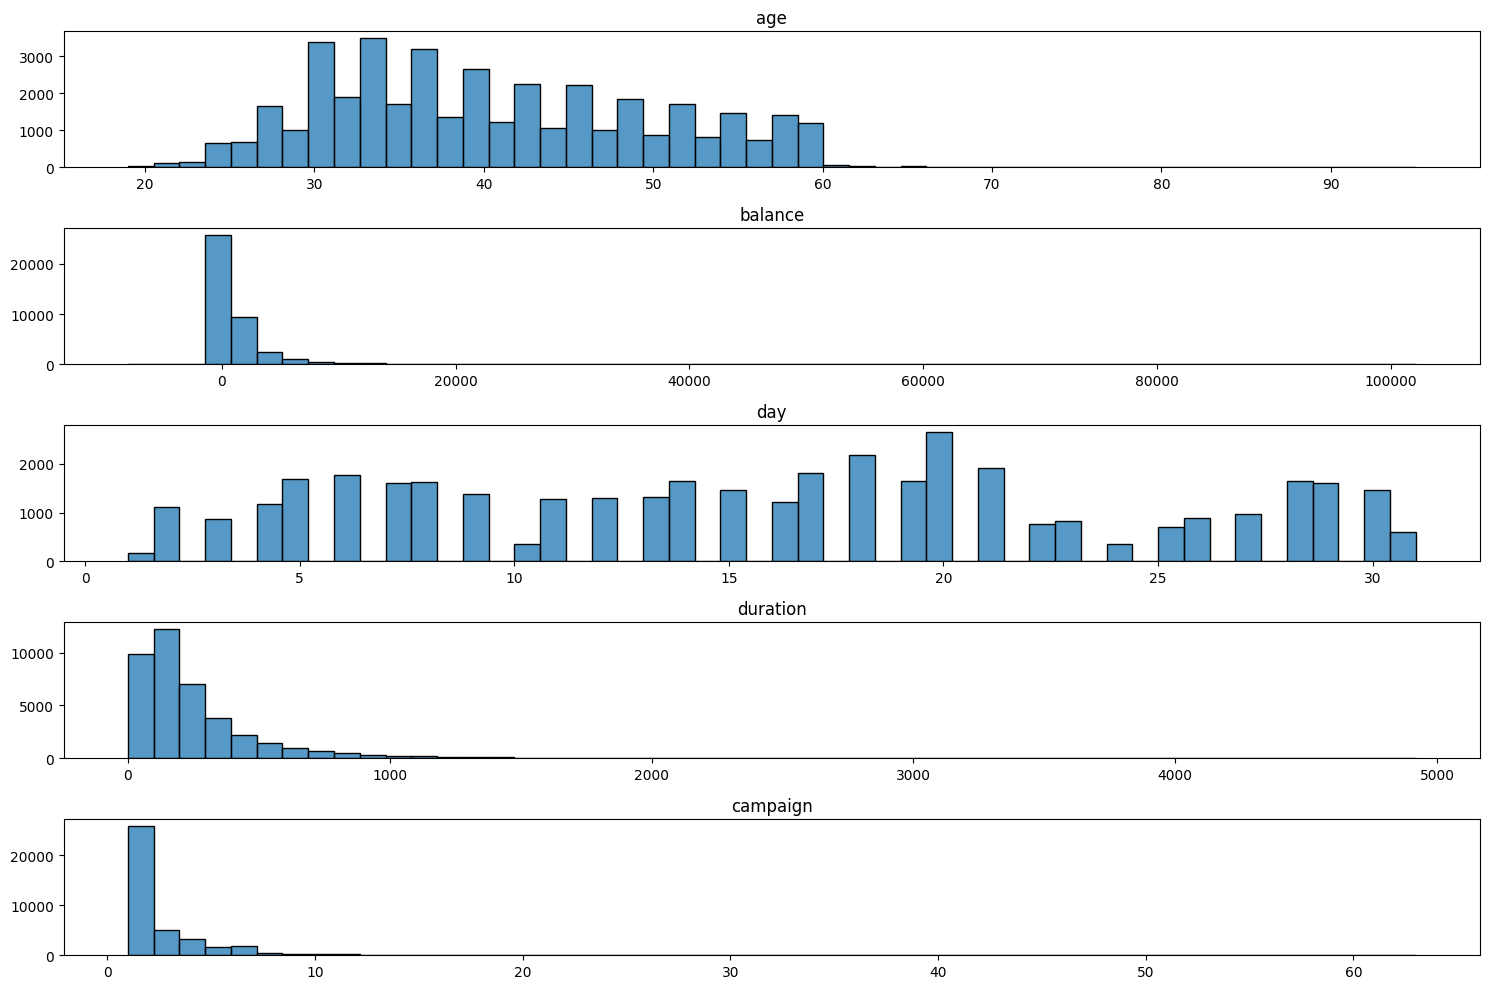

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

df_num = df[['age','balance','day','duration','campaign']]
fig, axes = plt.subplots(figsize=(15,10), ncols=1, nrows=5)
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.histplot(data = df_num.iloc[:, i], bins=50, ax=ax)
    ax.set_title(df_num.iloc[:,i].name)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

##### Boxplots

As can be seen above, age, balance, duration, campaign appear to contain a significant number of datapoints outside of the 75% range of the boxplots. However, removing outliers is tricky, so we will not do this here.

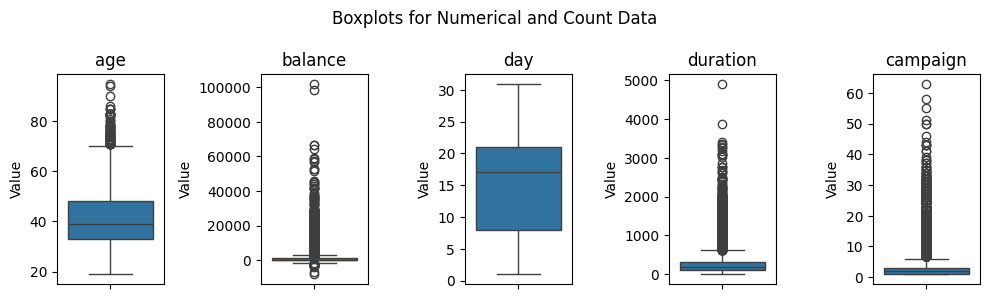

In [24]:
num_reduced_features = list(df_num.columns)
fig, axes = plt.subplots(figsize = (10,3), ncols = df_num.values.shape[-1], nrows = 1, sharex = True)
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.boxplot(y = df_num.values[:,i], ax = ax)
    ax.set_title(num_reduced_features[i])
    ax.set_ylabel("Value")

plt.suptitle("Boxplots for Numerical and Count Data")
plt.tight_layout()
plt.show()

##### Correlation Heatmap

As can be seen below, none of the numerical features show any strong correlation between each other, which is not surprising considering the nature of the features.

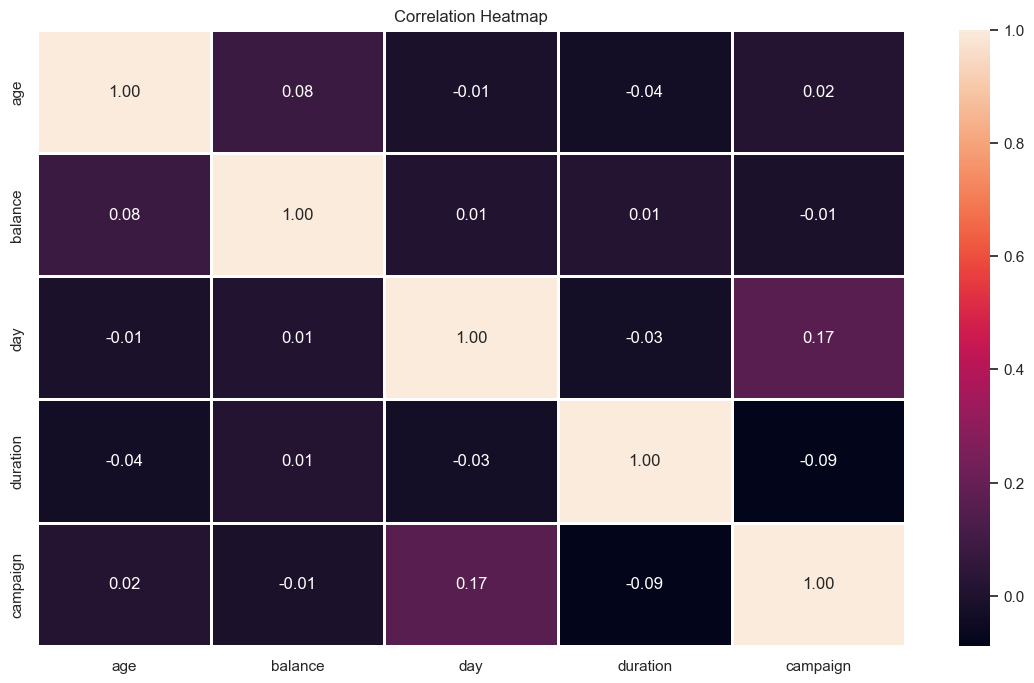

In [25]:
sns.set(rc={'figure.figsize': (14, 8)})
sns.heatmap(df_num.corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Correlation Heatmap")
plt.show()

### Analysis of Categorical Features

In [20]:
df_cat = df[['job','marital','education','contact','month']]

df_bin = df[['default','housing','loan','y']]


Below, can see that feature 'job' has large number of categories. Most common job is blue-collar.

<Axes: xlabel='job'>

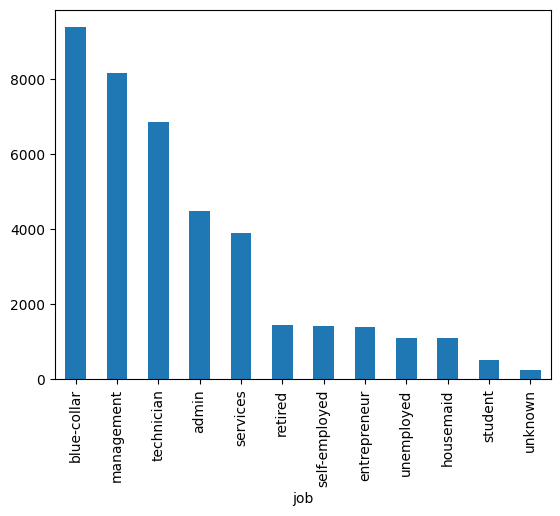

In [15]:
df_cat['job'].value_counts().plot(kind='bar')


<Axes: xlabel='marital'>

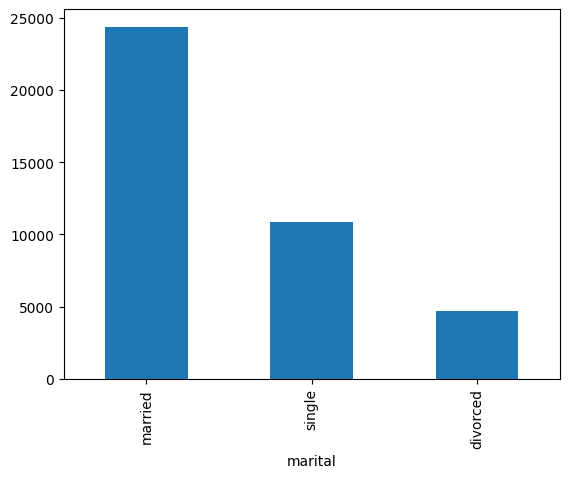

In [16]:
df_cat['marital'].value_counts().plot(kind='bar')


We have 'unknown' datapoints here which we may consider removing/imputing

<Axes: xlabel='education'>

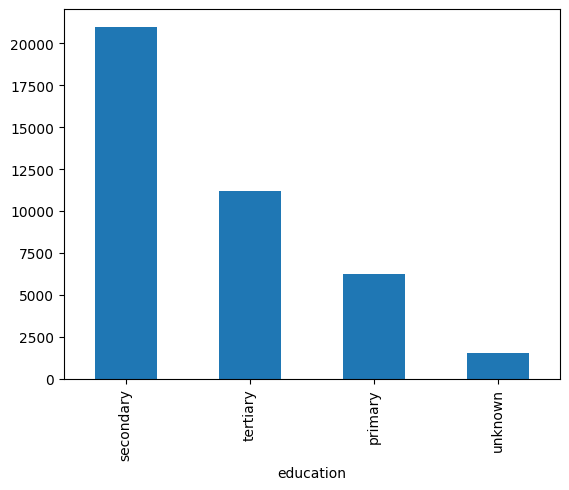

In [21]:
df_cat['education'].value_counts().plot(kind='bar')



We have 'unknown' data points here which we may consider removing/imputing if necessary

<Axes: xlabel='contact'>

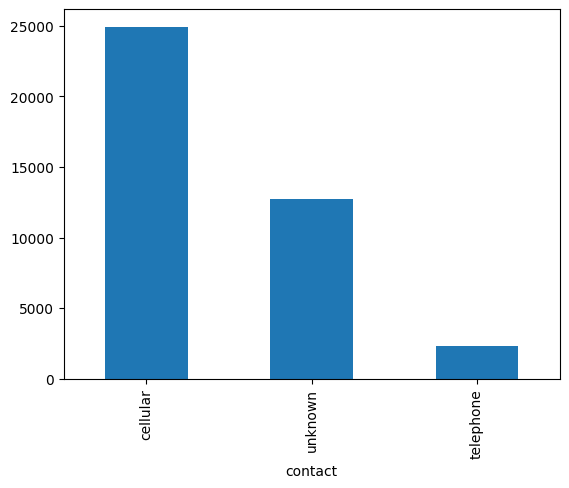

In [18]:
df_cat['contact'].value_counts().plot(kind='bar')


Many categories in 'month' feature. May consider cutting

<Axes: xlabel='month'>

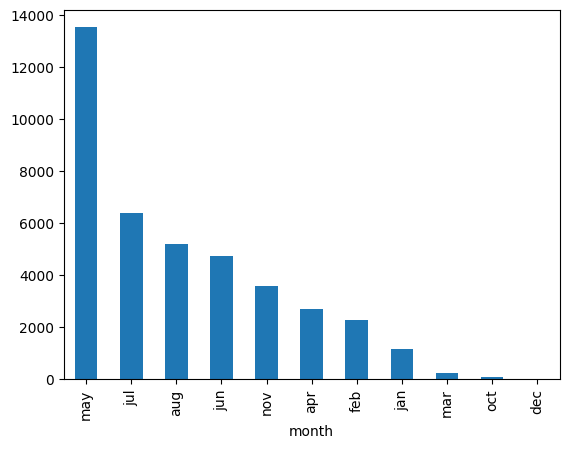

In [19]:
df_cat['month'].value_counts().plot(kind='bar')


'default' parameter is quite imbalanced

<Axes: xlabel='default'>

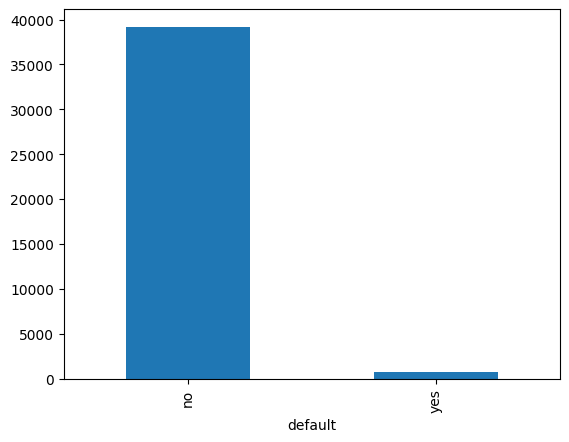

In [20]:
df_bin['default'].value_counts().plot(kind='bar')


<Axes: xlabel='loan'>

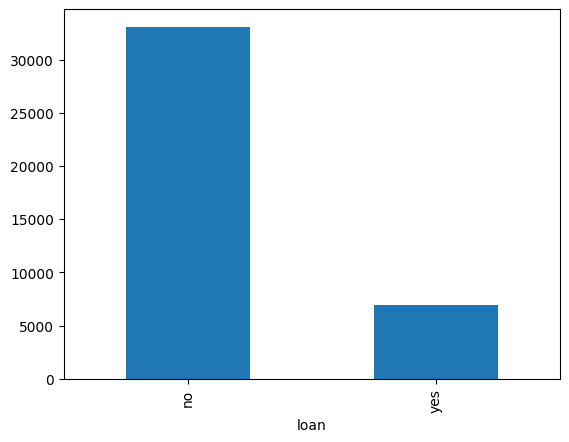

In [21]:
df_bin['loan'].value_counts().plot(kind='bar')


<Axes: xlabel='housing'>

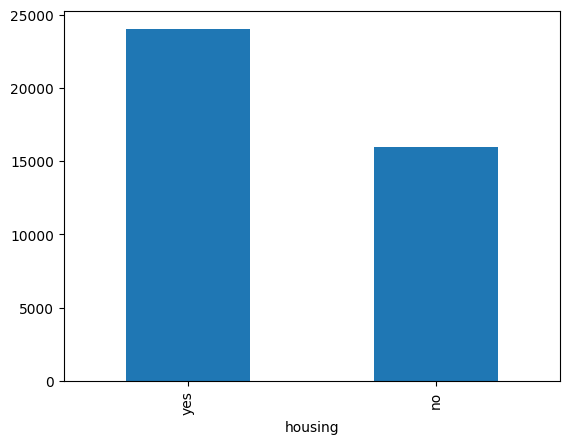

In [22]:
df_bin['housing'].value_counts().plot(kind='bar')


Target feature is very imbalanced

<Axes: xlabel='y'>

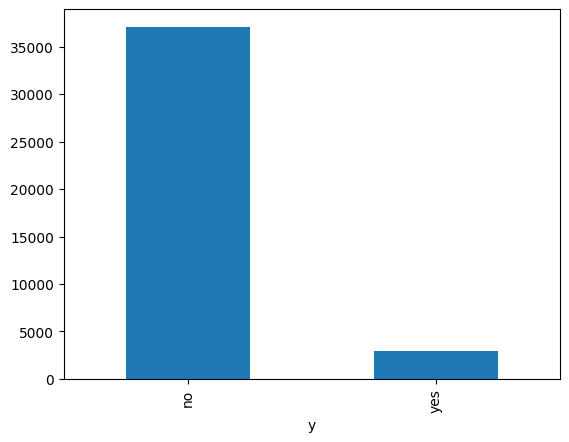

In [23]:
df_bin['y'].value_counts().plot(kind='bar')


### Observations and Comments

| Issue    | Consequences for Model |
|----------|----------|
|Large number of datapoints|Good, as the number of features we are working with is also quite large|
| Target variable is binary | Must one-hot encode | 
| Uneven split between y = 'yes' and  'no' cases | Dataset is quite imbalanced. Therefore, F1 score should be used as a score to optimize for. Furthermore, it may be good to attempt oversampling, if we encounter problems when implementing models. |
| Numerical features are not on same scale | Must implement min-max scaling of features |
| Many categorical/binary variables | Must implement one-hot encoding. However, this can lead to our feature space being quite large, as some features (noteably 'job' and 'month') have considerable number of values |
| 'education' and 'contact' features both contain a number of 'unkown' datapoints | Initially I considered removing these datapoints, as we are missing information. However, we will keep them for now, unless we otherwise see a reason to remove them. |



#### Creating Training and Test Data and Preproccessing Data

In [7]:
seed = random.randint(1000,9999)
seed

7122

In [9]:
seed = 7122

Below, we split our dataset into training and test datasets using an 80:20 split. We also ensure to stratify  our datasets, as our dataset is imbalanced with respect to our target variable.

In [11]:
X = df.drop(["y"], axis = 1) # defining feature matrix
features = X.columns.to_list() # creating list of features
y = df['y'] # defining target variable

enc = OneHotEncoder(drop='if_binary')

y = y.values
y = y.reshape(-1,1)
enc.fit(y)
y = enc.transform(y).toarray()

# splitting data and stratisfying based on country

strat = y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = seed, stratify=strat)

In [12]:
print(pd.Series(y_train.ravel()).value_counts(normalize=True)*100)
print(pd.Series(y_test.ravel()).value_counts(normalize=True)*100)

0.00   92.76
1.00    7.24
Name: proportion, dtype: float64
0.00   92.76
1.00    7.24
Name: proportion, dtype: float64


In [13]:
dict(list(zip(list(range(len(features))), features)))


{0: 'age',
 1: 'job',
 2: 'marital',
 3: 'education',
 4: 'default',
 5: 'balance',
 6: 'housing',
 7: 'loan',
 8: 'contact',
 9: 'day',
 10: 'month',
 11: 'duration',
 12: 'campaign'}

We now work with the preprocessing of our training and test datasets. We apply min-max scaling to our numerical features and one-hot encode our categorical features. Below, we can see that our preprocessed feature space consists of 41 features.

In [14]:
# numerical features to standardize (using min_max scaler)
num = ['age', 'balance','day','duration','campaign']
num_i = [0, 5, 9, 11, 12]

# categorical features to one-hot-encode
cat = ['job', 'marital', 'education', 'default','housing','loan','contact','month']
cat_i = [1, 2, 3, 4, 6, 7, 8, 10]

In [15]:
set_config(display='diagram')

# numerical features preprocessing
num_pre = Pipeline([
    ("num_scale", MinMaxScaler()),
])

# categorical features preprocessing
cat_pre = Pipeline([
    ("cat_encode", OneHotEncoder(drop='if_binary', sparse_output =False))
])


In [16]:
Preprocessor = Pipeline([
    ("pre_processing", ColumnTransformer([
        ("num_pre", num_pre, num_i), # Applied to the numerical variables
        ("cat_pre", cat_pre, cat_i)])), # Applied to the nominal variables 
])
display(Preprocessor)

Pipeline(steps=[('pre_processing',
                 ColumnTransformer(transformers=[('num_pre',
                                                  Pipeline(steps=[('num_scale',
                                                                   MinMaxScaler())]),
                                                  [0, 5, 9, 11, 12]),
                                                 ('cat_pre',
                                                  Pipeline(steps=[('cat_encode',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  [1, 2, 3, 4, 6, 7, 8,
                                                   10])]))])

In [17]:
X_train_pp = Preprocessor.fit_transform(X_train, y_train)
pd.DataFrame(X_train_pp).info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Columns: 41 entries, 0 to 40
dtypes: float64(41)
memory usage: 10.0 MB


In [18]:
X_test_pp = Preprocessor.fit_transform(X_test, y_test)
pd.DataFrame(X_test_pp).info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Columns: 41 entries, 0 to 40
dtypes: float64(41)
memory usage: 2.5 MB


In [19]:
feature_names = Preprocessor.named_steps["pre_processing"].get_feature_names_out(input_features=features)


Below, we save our test and training datasets to csv files, as the nature of our project requires us to do this to avoid data leakage.

In [21]:
X_train_pd = pd.DataFrame(X_train_pp,columns = feature_names)
X_test_pd = pd.DataFrame(X_test_pp,columns = feature_names)
X_train_pd.to_csv('X_train.csv',index=False)
X_test_pd.to_csv('X_test.csv',index=False)

Below, we create our customer training and test datasets, by removing features not related to our customers from our full test and training datasets.

In [22]:
features_to_remove = ["num_pre__day", 'num_pre__duration','num_pre__campaign','cat_pre__month_jan','cat_pre__month_feb','cat_pre__month_mar','cat_pre__month_apr','cat_pre__month_may','cat_pre__month_jun','cat_pre__month_jul','cat_pre__month_aug','cat_pre__month_oct','cat_pre__month_nov','cat_pre__month_dec']
X_train_customer_pd = X_train_pd.drop(features_to_remove, axis = 1)
X_test_customer_pd = X_test_pd.drop(features_to_remove, axis = 1)


In [23]:
X_train_customer_pd.to_csv('X_train_customer.csv',index=False)
X_test_customer_pd.to_csv('X_test_customer.csv',index=False)

In [25]:
np.savetxt('y_train.csv', y_train, delimiter=",")
np.savetxt('y_test.csv', y_test, delimiter=",")


In [9]:
X_train_pd = pd.read_csv('X_train.csv')
X_test_pd = pd.read_csv('X_test.csv')
X_train_customer_pd = pd.read_csv('X_train_customer.csv')
X_test_customer_pd = pd.read_csv('X_test_customer.csv')
y_train = pd.read_csv('y_train.csv', header=None)
y_test = pd.read_csv('y_test.csv', header=None)

y_train = y_train.values
y_test = y_test.values
X_train_customer = X_train_customer_pd.values
X_test_customer = X_test_customer_pd.values



feature_names = X_train_pd.columns
feature_names_customers = X_train_customer_pd.columns


## Customers Models

As our dataset is already imbalanced, we want to prioritize keeping as many positive cases as we can, while removing as many negative cases as possible. Therefore, we want to minimize the number of positive cases we accidentally classify as negative. Therefore, we should look at models with high recall scores, and we will maximise for recall in cross-validation.

In [15]:
def all_results(pipeline, X_test, y_train, y_test):

    y_probs = pipeline.predict_proba(X_test)[:, 1]
    y_pred = pipeline.predict(X_test)

    # get the confusion matrix as a numpy array
    confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
    # use the pretty function to make it nicer

    LE = LabelEncoder()
    y_train = LE.fit_transform(y_train)
    y_test = LE.transform(y_test)
    FP_i = [0,1]
    TN_i = [0,0]
    TP_i = [1,1]
    FN_i = [1,0]

    # Extracting the quantities from the confusion matrix 
    FP = confmat[0,1]
    TN = confmat[0,0]
    TP = confmat[1,1]
    FN = confmat[1,0]

    #Calculation of FPR, Recall, Precision, F1 Score, ROC_AUC, Accuracy
    # FPR
    FPR = (FP)/(FP+TN)
    # Recall
    Recall = (TP)/(TP+FN)
    Negative_Recall = (TN)/(TN+FP)

    # Precision
    Precision = (TP)/(FP+TP)
    # F1 Score
    F1 = 2 * (Precision * Recall)/(Precision + Recall)

    AUC = roc_auc_score(y_true = y_test, y_score = y_probs)

    accuracy = (TN+TP)/(TN+TP+FN+FP)

    print(classification_report(y_test, y_pred))

    pretty_confusion_matrix(confmat, LE.classes_, "",
                            labeling=True, highlight_indexes = [FP_i,FN_i,TP_i,TN_i])

    print('False Positive Rate (FPR): '+ '%.3f' % FPR)
    print('Recall: '+ '%.3f' % Recall)
    print('Negative Recall: '+'%.3f' % Negative_Recall)
    print('Precision: '+ '%.3f' % Precision)
    print('F1 Score: '+ '%.3f' % F1)
    print(f'ROC AUC = {AUC}')
    print(f'Accuracy = {accuracy}')

    return FPR, Recall, Negative_Recall, Precision, AUC, accuracy

#### Lazy Predict

Below, we attempt to understand which models may perform the best on our dataset, using lazypredict. Below, we can see that many models, while performing well according to accuracy, perform badly according to recall. As our priority is to keep as many positive points as possible, we want to maximise recall. For this reason, we will attempt to implement tree models (decision tree, bagging, lgbm), logistic regression and quadratic discriminant analysis for now. We will not try NearestCentroid, as this model offers little flexibility.

In [50]:
def recall_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fn) if (tp + fn) > 0 else 0

# Initialize LazyClassifier with the custom specificity function
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric = recall_score)

# Fit models and get results
models, predictions = clf.fit(X_train_customer_pd, X_test_customer_pd, y_train, y_test)

# Display results
print(models)

 97%|█████████▋| 31/32 [01:09<00:05,  5.85s/it]

[LightGBM] [Info] Number of positive: 2317, number of negative: 29683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 395
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072406 -> initscore=-2.550301
[LightGBM] [Info] Start training from score -2.550301


100%|██████████| 32/32 [01:10<00:00,  2.19s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.58               0.60     0.60      0.68   
QuadraticDiscriminantAnalysis      0.68               0.55     0.55      0.75   
DecisionTreeClassifier             0.85               0.53     0.53      0.86   
GaussianNB                         0.87               0.52     0.52      0.87   
ExtraTreeClassifier                0.86               0.52     0.52      0.87   
ExtraTreesClassifier               0.89               0.52     0.52      0.88   
RandomForestClassifier             0.91               0.51     0.51      0.89   
BaggingClassifier                  0.91               0.51     0.51      0.89   
KNeighborsClassifier               0.92               0.51     0.51      0.89   
PassiveAggressiveClassifier        0.85               0.51     0.51      0.86   
LGBMClassifier              

## Decision Tree

We first implement a decision tree model without any hyperparameter optimization. This model serves as a benchline model.

In [45]:
dt_pipeline = Pipeline(steps=[('model', DecisionTreeClassifier(random_state=seed))])

dt_pipeline.fit(X_train_customer,y_train)

tree_text = export_text(dt_pipeline[-1], feature_names=feature_names_customers, max_depth=3)
print(tree_text)

|--- num_pre__age <= 0.57
|   |--- cat_pre__contact_unknown <= 0.50
|   |   |--- cat_pre__marital_married <= 0.50
|   |   |   |--- num_pre__balance <= 0.07
|   |   |   |   |--- truncated branch of depth 33
|   |   |   |--- num_pre__balance >  0.07
|   |   |   |   |--- truncated branch of depth 38
|   |   |--- cat_pre__marital_married >  0.50
|   |   |   |--- num_pre__balance <= 0.08
|   |   |   |   |--- truncated branch of depth 35
|   |   |   |--- num_pre__balance >  0.08
|   |   |   |   |--- truncated branch of depth 39
|   |--- cat_pre__contact_unknown >  0.50
|   |   |--- num_pre__balance <= 0.07
|   |   |   |--- num_pre__age <= 0.11
|   |   |   |   |--- truncated branch of depth 14
|   |   |   |--- num_pre__age >  0.11
|   |   |   |   |--- truncated branch of depth 26
|   |   |--- num_pre__balance >  0.07
|   |   |   |--- num_pre__balance <= 0.07
|   |   |   |   |--- class: 1.0
|   |   |   |--- num_pre__balance >  0.07
|   |   |   |   |--- truncated branch of depth 24
|--- num_pre

Below, we can see that the model has high overall accuracy, but low recall score. It therefore makes sense to perform hyperparameter optimization to maximize for recall.

              precision    recall  f1-score   support

           0       0.93      0.90      0.92      7421
           1       0.11      0.15      0.13       579

    accuracy                           0.85      8000
   macro avg       0.52      0.53      0.52      8000
weighted avg       0.87      0.85      0.86      8000



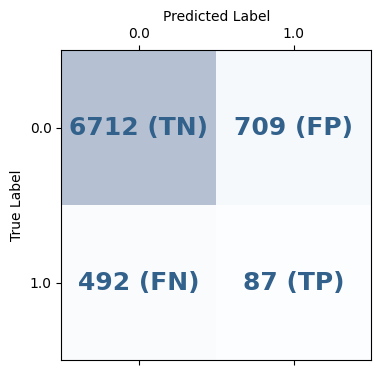

False Positive Rate (FPR): 0.096
Recall: 0.150
Negative Recall: 0.904
Precision: 0.109
F1 Score: 0.127
ROC AUC = 0.5279280266824368
Accuracy = 0.849875


In [48]:
FPR, Recall, Negative_Recall, Precision, AUC, accuracy = all_results(dt_pipeline, X_test_customer, y_train, y_test)

Below, we have plotted the importance of our features in our models. We can see that Bank account balance and age are two most significant indicators.

NameError: name 'fig' is not defined

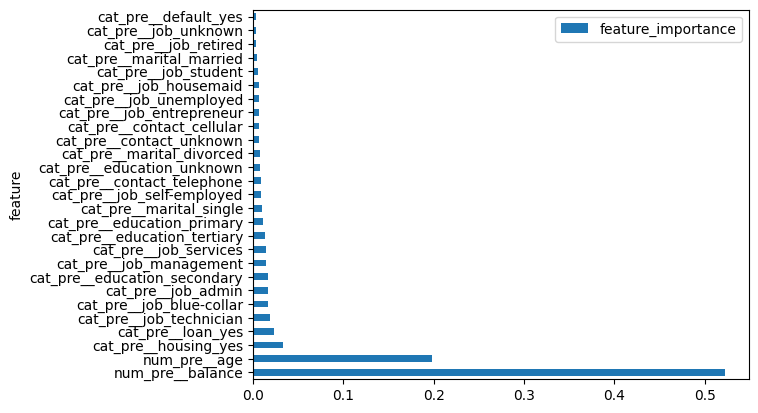

In [52]:
plot_feature_importance(dt_pipeline[-1], feature_names_customers)

#### Hyperparameter Optimization

Below, we implement hyperparameter optimization and RFE, using hyperopt. The number of features to select is a hyperparameter in the optimization.

In [60]:
# Define the objective function
def objective(params):
    # the number of features, ensuring it is an integer
    n_features = int(params['n_features'])
    
    # Set up classifier hyperparameters 
    dt_params = {
        'max_depth': int(params['max_depth']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'class_weight': params['class_weight'],
        'criterion': params['criterion'],
        'random_state': int(params['random_state']),
    }


    classifier_for_rfe = DecisionTreeClassifier(**dt_params)
    
    # Set up the RFE with the classifier as the estimator
    rfe = RFE(estimator=classifier_for_rfe, n_features_to_select=n_features)
    
    classifier_final = DecisionTreeClassifier(**dt_params)

    # Create a pipeline that first does feature selection, then classification
    pipeline = Pipeline(steps=[('rfe', rfe), ('clf', classifier_final)])
    
    # Use cross-validation to evaluate performance using recall
    score = cross_val_score(pipeline, X_train_customer, y_train, scoring='recall', cv=5).mean()
    
    # Hyperopt minimizes the objective, so return the negative score (to maximize recall)
    return {'loss': -score, 'status': STATUS_OK}

# Define the hyperparameter search space using hp.choice for discrete parameters
search_space = {
    'n_features': hp.choice('n_features', list(np.arange(1, 28, 1, dtype=int))),
    'max_depth': hp.choice('max_depth', list(np.arange(3, 15, 1, dtype=int))),
    'min_samples_split': hp.choice('min_samples_split', list(np.arange(2, 10, 1, dtype=int))),
    'min_samples_leaf': hp.choice('min_samples_leaf', list(np.arange(1, 8, 1, dtype=int))),
    'class_weight': hp.choice('class_weight', [None, "balanced"]),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'random_state': hp.choice('random_state', [seed])  # Ensure 'seed' is defined
}

# Run Hyperopt
trials = Trials()
best = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=300,
    trials=trials
)

best_params = space_eval(search_space, best)
print("Best hyperparameters:", best_params)


  0%|          | 0/300 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 300/300 [35:28<00:00,  7.10s/trial, best loss: -0.6460694868548448]
Best hyperparameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': np.int64(8), 'min_samples_leaf': np.int64(7), 'min_samples_split': np.int64(6), 'n_features': np.int64(9), 'random_state': 7122}


Below, we fit our hyperparmater optimized model. We see that the model uses 9 features, all displayed below.

In [11]:
best_params_dtc = {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': np.int64(8), 'min_samples_leaf': np.int64(7), 'min_samples_split': np.int64(6), 'n_features': np.int64(9), 'random_state': 7122}
n_features_dtc = int(best_params_dtc['n_features'])
del best_params_dtc['n_features']



classifier_for_rfe = DecisionTreeClassifier(**best_params_dtc)
    
# Set up the RFE with the classifier as the estimator
rfe = RFE(estimator=classifier_for_rfe, n_features_to_select=n_features_dtc)

classifier_final = DecisionTreeClassifier(**best_params_dtc)


# Create a pipeline that first does feature selection, then classification
dtc_pipeline = Pipeline(steps=[('rfe', rfe), ('clf', classifier_final)])
dtc_pipeline.fit(X_train_customer, y_train)


mask = dtc_pipeline.named_steps['rfe'].support_
selected_feature_names = feature_names_customers[mask]
print("Selected features:", selected_feature_names)



Selected features: Index(['num_pre__age', 'num_pre__balance', 'cat_pre__job_management',
       'cat_pre__marital_married', 'cat_pre__education_tertiary',
       'cat_pre__education_unknown', 'cat_pre__housing_yes',
       'cat_pre__loan_yes', 'cat_pre__contact_unknown'],
      dtype='object')


In [12]:
from sklearn.tree import export_text
tree_text = export_text(dtc_pipeline[-1], feature_names=selected_feature_names, max_depth=3)
print(tree_text)

|--- cat_pre__contact_unknown <= 0.50
|   |--- num_pre__age <= 0.55
|   |   |--- cat_pre__marital_married <= 0.50
|   |   |   |--- num_pre__balance <= 0.07
|   |   |   |   |--- truncated branch of depth 5
|   |   |   |--- num_pre__balance >  0.07
|   |   |   |   |--- truncated branch of depth 5
|   |   |--- cat_pre__marital_married >  0.50
|   |   |   |--- num_pre__balance <= 0.08
|   |   |   |   |--- truncated branch of depth 5
|   |   |   |--- num_pre__balance >  0.08
|   |   |   |   |--- truncated branch of depth 5
|   |--- num_pre__age >  0.55
|   |   |--- num_pre__balance <= 0.07
|   |   |   |--- class: 1.0
|   |   |--- num_pre__balance >  0.07
|   |   |   |--- num_pre__balance <= 0.07
|   |   |   |   |--- truncated branch of depth 3
|   |   |   |--- num_pre__balance >  0.07
|   |   |   |   |--- truncated branch of depth 5
|--- cat_pre__contact_unknown >  0.50
|   |--- num_pre__balance <= 0.07
|   |   |--- cat_pre__education_unknown <= 0.50
|   |   |   |--- num_pre__balance <= 0.0

The model results on the test dataset are shown below. As we can see, the model has a recall score of 0.76. Therefore, the model accidentally eliminates 24% of positive cases. However, it also correctly classifies 3328 negative cases. 

              precision    recall  f1-score   support

           0       0.96      0.45      0.61      7421
           1       0.10      0.76      0.17       579

    accuracy                           0.47      8000
   macro avg       0.53      0.61      0.39      8000
weighted avg       0.90      0.47      0.58      8000



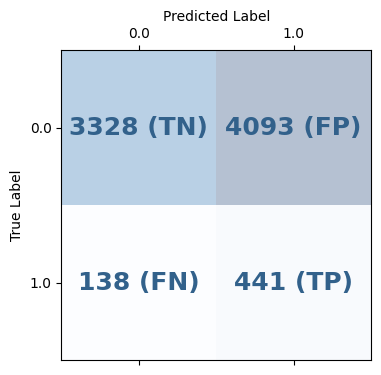

False Positive Rate (FPR): 0.552
Recall: 0.762
Negative Recall: 0.448
Precision: 0.097
F1 Score: 0.173
ROC AUC = 0.6265857591733677
Accuracy = 0.471125


In [13]:
FPR, Recall, Negative_Recall, Precision, AUC, accuracy = all_results(dtc_pipeline, X_test_customer, y_train, y_test)

The realtive feature importances are plotted below. Again balance and age come top. Contact unknown also appears as a significant feature.

NameError: name 'fig' is not defined

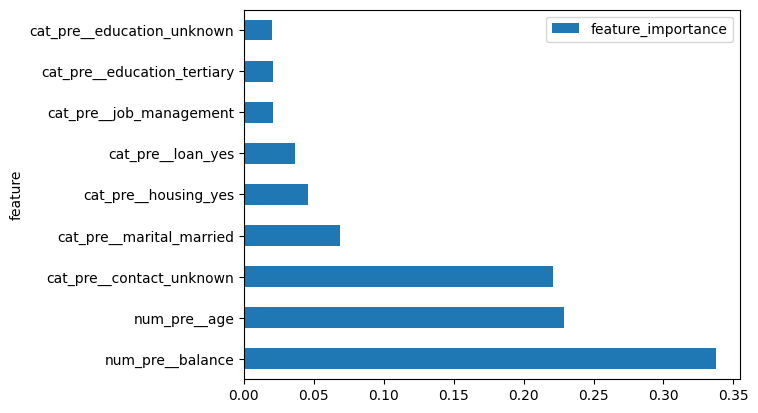

In [14]:
plot_feature_importance(dtc_pipeline[-1], selected_feature_names)

#### Logistic Regression

As a baseline model, we will implement a logistic regression model without any hyperparameter optimization. The results are given below. As we can see, all datapoints are classified as negative, which is not what we want, as recall is zero. We'll perform hyperparameter optimization to see if we can improve results here.

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      7421
           1       0.00      0.00      0.00       579

    accuracy                           0.93      8000
   macro avg       0.46      0.50      0.48      8000
weighted avg       0.86      0.93      0.89      8000



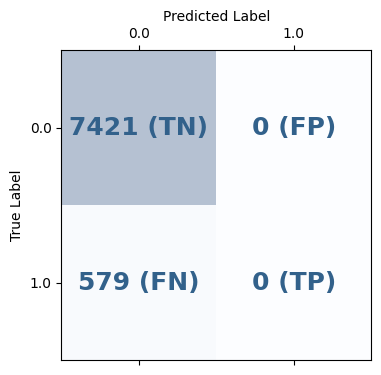

False Positive Rate (FPR): 0.000
Recall: 0.000
Negative Recall: 1.000
Precision: nan
F1 Score: nan
ROC AUC = 0.6502702385681859
Accuracy = 0.927625


In [65]:
classifier_final = LogisticRegression()
pipeline_log_baseline = Pipeline(steps=[ ('clf', classifier_final)])
pipeline_log_baseline.fit(X_train_customer,y_train)

FPR, Recall, Negative_Recall, Precision, AUC, accuracy = all_results(pipeline_log_baseline, X_test_customer, y_train, y_test)


In [69]:
def objective(params):

    n_features = int(params['n_features'])

    log_params = {
        'C': params['C'],
        'class_weight': params['class_weight'],
        'penalty': params['penalty'],
        'random_state': params['random_state'],
        'solver' : params['solver']
    
    }

    if params['penalty'] == 'elasticnet':
        log_params['l1_ratio'] = params['l1_ratio']
    else:
        log_params['l1_ratio'] = None


    # Create an instance for RFE
    classifier_for_rfe = LogisticRegression(**log_params)
    rfe = RFE(estimator=classifier_for_rfe, 
              n_features_to_select=n_features)

    # Create a new instance for the final classifier
    classifier_final = LogisticRegression(**log_params)
    pipeline = Pipeline(steps=[('rfe', rfe), ('clf', classifier_final)])

    # Use cross-validation to evaluate performance using negative recall
    score = cross_val_score(pipeline, X_train_customer, y_train, scoring='recall', cv=5).mean()
    
    # Hyperopt minimizes the objective, so return the negative score (to maximize negative recall)
    return {'loss': -score, 'status': STATUS_OK}




search_space = {
    'n_features' : hp.choice('n_features', [5,10,15,20,25]), 
    'C': hp.loguniform('C', -5, 25),  
    'class_weight': hp.choice('class_weight', [None, "balanced"]),
    'penalty' : hp.choice('penalty', ['l1', 'l2','elasticnet', None]),
    'l1_ratio': hp.uniform('l1_ratio', 0, 1),
    'random_state' : hp.choice('random_state', [int(seed)]),
    'solver' : hp.choice('solver', ['saga'])
}

trials = Trials()
best = fmin(
    fn = objective,
    space = search_space,
    algo = tpe.suggest,
    max_evals=100,
    trials = trials
)

best_params = space_eval(search_space, best)
print("Best hyperparameters:", best_params)



100%|██████████| 100/100 [2:15:38<00:00, 81.38s/trial, best loss: -0.7716895062188127]  
Best hyperparameters: {'C': 2.5624013340251084, 'class_weight': 'balanced', 'l1_ratio': 0.7050230011920622, 'n_features': 5, 'penalty': 'elasticnet', 'random_state': 7122, 'solver': 'saga'}


Below, we fit the hyperparameter optmized logistic regression model. As we can see, the model takes 5 features, which are all printed below.

In [10]:
log_params = {'C': 2.5624013340251084, 'class_weight': 'balanced', 'l1_ratio': 0.7050230011920622, 'n_features': 5, 'penalty': 'elasticnet', 'random_state': 7122, 'solver': 'saga'}


n_features = int(log_params['n_features'])

del log_params['n_features']

# Create an instance for RFE
classifier_for_rfe = LogisticRegression(**log_params)

rfe = RFE(estimator=classifier_for_rfe, 
              n_features_to_select=n_features)

# Create a new instance for the final classifier
classifier_final = LogisticRegression(**log_params)
log_pipeline = Pipeline(steps=[('rfe', rfe), ('clf', classifier_final)])


log_pipeline.fit(X_train_customer,y_train)
mask = log_pipeline.named_steps['rfe'].support_
selected_feature_names_log = feature_names_customers[mask]

print("Selected features:", selected_feature_names_log)




Selected features: Index(['num_pre__age', 'num_pre__balance', 'cat_pre__job_retired',
       'cat_pre__job_student', 'cat_pre__contact_unknown'],
      dtype='object')


The values of the feature coefficients are shown below. Positive features inidicate that an increased value of the feature is correlated with a higher likelihood of the individual subscribing. Again, we can see that age and bank account balance are both indicative of an individual subscribing. Furthermore, the individual being retired increases chances, while an individual being a student lowers the probability they'll subscribe.

Coefficients of the best logistic regression model:
[-0.89687103  4.29868282  0.67392799  0.6879873  -0.84878156]
Intercept of the best logistic regression model:
-0.8968710340723197


NameError: name 'Patch' is not defined

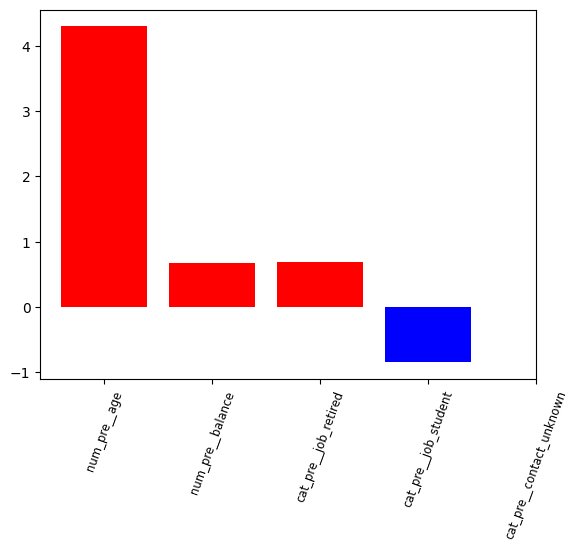

In [11]:
coefficients = log_pipeline.named_steps['clf'].coef_[0]
print("Coefficients of the best logistic regression model:")
print(coefficients)
print('Intercept of the best logistic regression model:')
print(coefficients[0])

plot_coefs(coefficients[1:], selected_feature_names_log, 'Coefficient Values for Features')

The model performance on the test data is shown below. As we can see the model has a high recall score (0.78). It also correctly classifies 2728 negative cases.

              precision    recall  f1-score   support

           0       0.96      0.37      0.53      7421
           1       0.09      0.79      0.16       579

    accuracy                           0.40      8000
   macro avg       0.52      0.58      0.35      8000
weighted avg       0.89      0.40      0.50      8000



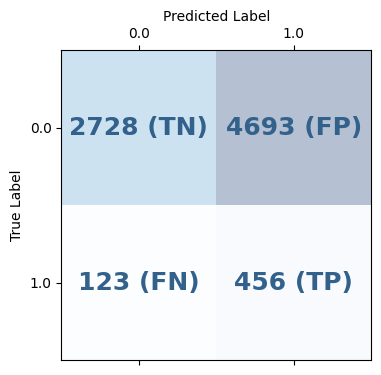

False Positive Rate (FPR): 0.632
Recall: 0.788
Negative Recall: 0.368
Precision: 0.089
F1 Score: 0.159
ROC AUC = 0.6216310945063477
Accuracy = 0.398


In [12]:
FPR, Recall, Negative_Recall, Precision, AUC, accuracy = all_results(log_pipeline, X_test_customer, y_train, y_test)


#### Quadratic Discriminant Analysis

The baseline model was implemented and the results are shown below. As we can see, the model eliminates a large number of correctly classified negative cases (3541), but it also accidentally eliminates almost 40% of positive cases. We attempted improving this baseline model with hyperparameter optimization, but found that baseline model and parameter settings yielded best results, as shown below. Furthermore this model does not provide a framework for examining feature importance.

              precision    recall  f1-score   support

           0       0.94      0.48      0.63      7421
           1       0.08      0.60      0.15       579

    accuracy                           0.49      8000
   macro avg       0.51      0.54      0.39      8000
weighted avg       0.88      0.49      0.60      8000



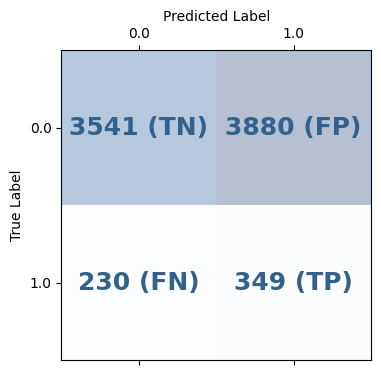

False Positive Rate (FPR): 0.523
Recall: 0.603
Negative Recall: 0.477
Precision: 0.083
F1 Score: 0.145
ROC AUC = 0.5554730902989905
Accuracy = 0.48625


In [11]:
classifier_final = QuadraticDiscriminantAnalysis()

pipeline_quad_baseline = Pipeline(steps=[ ('clf', classifier_final)])
pipeline_quad_baseline.fit(X_train_customer,y_train)


FPR, Recall, Negative_Recall, Precision, AUC, accuracy = all_results(pipeline_quad_baseline, X_test_customer, y_train, y_test)


#### Voting Classifier

As a final model attempt, we implement a soft-voting classifier with the decision tree model and logistic regression model, using the optimized hyperparameters from before.

In [37]:
## DTC

best_params_dtc =  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': np.int64(8), 'min_samples_leaf': np.int64(7), 'min_samples_split': np.int64(6), 'n_features': np.int64(9), 'random_state': 7122}
n_features_dtc = int(best_params_dtc['n_features'])
del best_params_dtc['n_features']



classifier_for_rfe_dt = DecisionTreeClassifier(**best_params_dtc)
    
# Set up the RFE with the classifier as the estimator
rfe = RFE(estimator=classifier_for_rfe_dt, n_features_to_select=n_features_dtc)

# Create a pipeline that first does feature selection, then classification
dtc_pipeline = Pipeline(steps=[('rfe', rfe), ('clf', DecisionTreeClassifier(**best_params_dtc))])

## Logistic Regression

log_params = {'C': 2.5624013340251084, 'class_weight': 'balanced', 'l1_ratio': 0.7050230011920622, 'n_features': 5, 'penalty': 'elasticnet', 'random_state': 7122, 'solver': 'saga'}
n_features_log = int(log_params['n_features'])
del log_params['n_features']

# Create an instance for RFE
classifier_for_rfe_log = LogisticRegression(**log_params)

rfe = RFE(estimator=classifier_for_rfe_log, 
              n_features_to_select=n_features_log)

log_pipeline = Pipeline(steps=[('rfe', rfe), ('clf', LogisticRegression(**log_params))])



# Quad
quad_pipeline = Pipeline(steps=[('clf', QuadraticDiscriminantAnalysis())])


estimators = [('dtc',dtc_pipeline),('log',log_pipeline)]

In [38]:
vote_clf = VotingClassifier(
    estimators=estimators, voting='soft'
)

vote_clf.fit(X_train_customer, y_train)


VotingClassifier(estimators=[('dtc',
                              Pipeline(steps=[('rfe',
                                               RFE(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                    criterion='entropy',
                                                                                    max_depth=np.int64(8),
                                                                                    min_samples_leaf=np.int64(7),
                                                                                    min_samples_split=np.int64(6),
                                                                                    random_state=7122),
                                                   n_features_to_select=9)),
                                              ('clf',
                                               DecisionTreeClassifier(class_weight='balanced',
                                                                      criterion='entropy',
                                                                      max_depth=n...
                                               RFE(estimator=LogisticRegression(C=2.5624013340251084,
                                                                                class_weight='balanced',
                                                                                l1_ratio=0.7050230011920622,
                                                                                penalty='elasticnet',
                                                                                random_state=7122,
                                                                                solver='saga'),
                                                   n_features_to_select=5)),
                                              ('clf',
                                               LogisticRegression(C=2.5624013340251084,
                                                                  class_weight='balanced',
                                                                  l1_ratio=0.7050230011920622,
                                                                  penalty='elasticnet',
                                                                  random_state=7122,
                                                                  solver='saga'))]))],
                 voting='soft')

The results on the test datasets are shown below. As we can see the model correctly 

              precision    recall  f1-score   support

           0       0.96      0.46      0.62      7421
           1       0.10      0.74      0.17       579

    accuracy                           0.48      8000
   macro avg       0.53      0.60      0.39      8000
weighted avg       0.90      0.48      0.59      8000



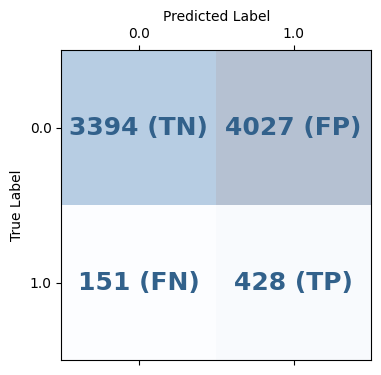

False Positive Rate (FPR): 0.543
Recall: 0.739
Negative Recall: 0.457
Precision: 0.096
F1 Score: 0.170
ROC AUC = 0.6342475805601384
Accuracy = 0.47775


In [ ]:
FPR, Recall, Negative_Recall, Precision, AUC, accuracy = all_results(vote_clf, X_test_customer, y_train, y_test)

#### Final Customer Model Proposal

In this section, we found that the two best performing models were the decision tree and logistic regression models. While the logistic regression model scored slightly higher than the decision tree model (78% vs 76%), the decision tree model correctly classified 600 more negative cases than the logistic regression model. Thus, the marginal benefit of saving a few positive cases is outweighed by the cost of calling an extra 600 negative cases. Therefore, the decision tree model offers the best solution for this section, as it eliminates a large number of negative cases, while keeping 76% of all positive cases. 

From our analysis of multiple models in this section, we found that certain features appeared to consistently be ranked as most important. These were account balance and age. Therefore, in addition to implementing our model when deciding which potential customers to call, we recommend calling older customers with larger account balances as a general rule of thumb. 

Below, we filter out from our test dataset all datapoints classified as negative according our model. 

In [15]:
# Get predictions using the customer-only features
predictions = dtc_pipeline.predict(X_test_customer)

# Create a boolean mask: True for rows where the prediction is positive (i.e. 1)
mask = predictions == 1

# Filter the full feature set and corresponding labels
X_test_filtered = X_test_pd[mask]
y_test_filtered = y_test[mask]


# Call Model

In this section of the project, we attempt to create a classification model for test dataset that has been filtered by the Customer Model. Below, we create training and test datasets from the filtered dataset. As our dataset is still imbalanced, and we want a model that performs well overall, we will use the F1 and Recall scores as our scores to optimize over in hyperparameter optimization.

In [19]:
strat = y_test_filtered

X_train_call, X_test_call, y_train_call, y_test_call = train_test_split(X_test_filtered, y_test_filtered, test_size = 0.2, 
                                                    random_state = seed, stratify=strat)

Below, we can see that the positive cases make up roughly 9.7% of the dataset, which is up from around 7% in the unfiltered dataset.

In [20]:
print(pd.Series(y_train_call.ravel()).value_counts(normalize=True)*100)
print(pd.Series(y_test_call.ravel()).value_counts(normalize=True)*100)

0.00   90.27
1.00    9.73
Name: proportion, dtype: float64
0.00   90.30
1.00    9.70
Name: proportion, dtype: float64


Below, we save the test and training datasets to csv files, to prevent data leakage.

In [25]:
X_train_call.to_csv('X_train_call.csv',index=False)
X_test_call.to_csv('X_test_call.csv',index=False)
np.savetxt('y_train_call.csv', y_train_call, delimiter=",")
np.savetxt('y_test_call.csv', y_test_call, delimiter=",")


In [7]:
X_train_call = pd.read_csv('X_train_call.csv')
X_test_call = pd.read_csv('X_test_call.csv')
y_train_call = pd.read_csv('y_train_call.csv', header=None)
y_test_call = pd.read_csv('y_test_call.csv', header=None)

y_train_call = y_train_call.values
y_test_call = y_test_call.values

Below, we use lazypredict to see which models are likely to perform well for our dataset. We can see that tree models perform well, according to accuracy and f1 scores. Furthermore, SVC and logistic regression appear to perform fairly well. In this section, I will try to implement decision tree classifier, SVC, logistic regression, before creating a voting ensemble model with these models.

In [31]:
# Initialize LazyClassifier with the custom specificity function
clf = LazyClassifier(verbose=0, ignore_warnings=True)

# Fit models and get results
models, predictions = clf.fit(X_train_call, X_test_call, y_train_call, y_test_call)

# Display results
print(models)

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:05<00:00,  6.06it/s]

[LightGBM] [Info] Number of positive: 353, number of negative: 3274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 3627, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097326 -> initscore=-2.227300
[LightGBM] [Info] Start training from score -2.227300
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.86               0.82     0.82      0.88   
LGBMClassifier                     0.91               0.71     0.71      0.90   
DecisionTreeClassifier             0.89               0.71     0.71      0.89   
Perceptron                         0.86   

## Decision Tree Classifier

We first try implementing a baseline decision tree model without any hyperparameter optimization.

In [32]:
dt_pipeline = Pipeline(steps=[('model', DecisionTreeClassifier(random_state=seed))])

dt_pipeline.fit(X_train_call,y_train_call)

tree_text = export_text(dt_pipeline[-1], feature_names=feature_names, max_depth=3)
print(tree_text)

|--- num_pre__duration <= 0.16
|   |--- num_pre__duration <= 0.11
|   |   |--- cat_pre__month_mar <= 0.50
|   |   |   |--- num_pre__age <= 0.57
|   |   |   |   |--- truncated branch of depth 15
|   |   |   |--- num_pre__age >  0.57
|   |   |   |   |--- truncated branch of depth 3
|   |   |--- cat_pre__month_mar >  0.50
|   |   |   |--- num_pre__day <= 0.43
|   |   |   |   |--- truncated branch of depth 6
|   |   |   |--- num_pre__day >  0.43
|   |   |   |   |--- truncated branch of depth 4
|   |--- num_pre__duration >  0.11
|   |   |--- cat_pre__month_jul <= 0.50
|   |   |   |--- num_pre__day <= 0.95
|   |   |   |   |--- truncated branch of depth 13
|   |   |   |--- num_pre__day >  0.95
|   |   |   |   |--- truncated branch of depth 2
|   |   |--- cat_pre__month_jul >  0.50
|   |   |   |--- num_pre__duration <= 0.15
|   |   |   |   |--- class: 0.0
|   |   |   |--- num_pre__duration >  0.15
|   |   |   |   |--- truncated branch of depth 2
|--- num_pre__duration >  0.16
|   |--- num_pre_

Results given below, as we can see, accuracy is heigh, but many positive cases are misclassified as negative (only 51% recall). The overall F1 score is 0.484. We can therefore try implementing hyperparameter optimization to improve upon results.

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       819
           1       0.46      0.51      0.48        88

    accuracy                           0.89       907
   macro avg       0.70      0.72      0.71       907
weighted avg       0.90      0.89      0.90       907



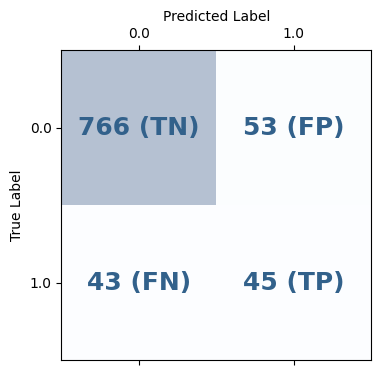

False Positive Rate (FPR): 0.065
Recall: 0.511
Negative Recall: 0.935
Precision: 0.459
F1 Score: 0.484
ROC AUC = 0.7233252858252858
Accuracy = 0.8941565600882029


In [33]:
FPR, Recall, Negative_Recall, Precision, AUC, accuracy = all_results(dt_pipeline, X_test_call, y_train_call, y_test_call)

The relative importance of the features in the model are plotted below. As we can see, the most important feature by far is duration of call. Other significant features are account balance, day of the month and customer age. Thus, we see the importance of account balance and customer age in this model, like we saw in the Customer Model.

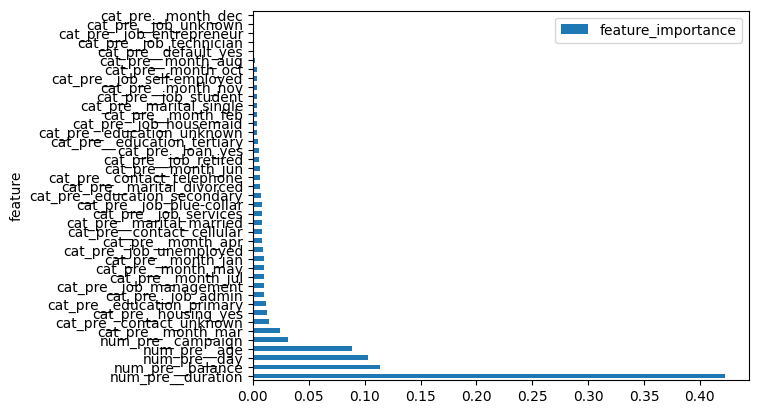

In [38]:
plot_feature_importance(dt_pipeline[-1], feature_names)

Below, we try implementing hyperparameter optimization, using RFE. Here, we look to optimize for recall score, as our dataset is imbalanced.

In [10]:
# Define the objective function
def objective(params):
    # the number of features, ensuring it is an integer
    n_features = int(params['n_features'])
    
    # Set up classifier hyperparameters 
    dt_params = {
        'max_depth': int(params['max_depth']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'class_weight': params['class_weight'],
        'criterion': params['criterion'],
        'random_state': int(params['random_state']),
    }


    classifier_for_rfe = DecisionTreeClassifier(**dt_params)
    
    # Set up the RFE with the classifier as the estimator
    rfe = RFE(estimator=classifier_for_rfe, n_features_to_select=n_features)
    
    classifier_final = DecisionTreeClassifier(**dt_params)

    # Create a pipeline that first does feature selection, then classification
    pipeline = Pipeline(steps=[('rfe', rfe), ('clf', classifier_final)])
    
    # Use cross-validation to evaluate performance using negative recall
    score = cross_val_score(pipeline, X_train_call, y_train_call, scoring='recall', cv=5).mean()
    
    # Hyperopt minimizes the objective, so return the negative score (to maximize negative recall)
    return {'loss': -score, 'status': STATUS_OK}

# Define the hyperparameter search space using hp.choice for discrete parameters
search_space = {
    'n_features': hp.choice('n_features', list(np.arange(1, 40, 1, dtype=int))),
    'max_depth': hp.choice('max_depth', list(np.arange(3, 15, 1, dtype=int))),
    'min_samples_split': hp.choice('min_samples_split', list(np.arange(2, 10, 1, dtype=int))),
    'min_samples_leaf': hp.choice('min_samples_leaf', list(np.arange(1, 8, 1, dtype=int))),
    'class_weight': hp.choice('class_weight', [None, "balanced"]),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'random_state': hp.choice('random_state', [seed])  # Ensure 'seed' is defined
}

# Run Hyperopt
trials = Trials()
best = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=250,
    trials=trials
)

best_params = space_eval(search_space, best)
print("Best hyperparameters:", best_params)


  0%|          | 0/250 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 250/250 [05:44<00:00,  1.38s/trial, best loss: -0.827122736418511] 
Best hyperparameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': np.int64(6), 'min_samples_leaf': np.int64(6), 'min_samples_split': np.int64(8), 'n_features': np.int64(10), 'random_state': 7122}


The model with optimized hyperparameters is implemented below. We can see that the model uses 20 of the 41 features, which are printed below.

In [12]:
# f1
#best_params_dtc = {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': np.int64(6), 'min_samples_leaf': np.int64(6), 'min_samples_split': np.int64(2), 'n_features': np.int64(37), 'random_state': 7122}
best_params_dtc = {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': np.int64(6), 'min_samples_leaf': np.int64(6), 'min_samples_split': np.int64(8), 'n_features': np.int64(10), 'random_state': 7122}
n_features_dtc = int(best_params_dtc['n_features'])
del best_params_dtc['n_features']



classifier_for_rfe = DecisionTreeClassifier(**best_params_dtc)
    
# Set up the RFE with the classifier as the estimator
rfe = RFE(estimator=classifier_for_rfe, n_features_to_select=n_features_dtc)

classifier_final = DecisionTreeClassifier(**best_params_dtc)


# Create a pipeline that first does feature selection, then classification
dtc_pipeline = Pipeline(steps=[('rfe', rfe), ('clf', classifier_final)])
dtc_pipeline.fit(X_train_call, y_train_call)


mask = dtc_pipeline.named_steps['rfe'].support_
selected_feature_names = X_train_call.columns[mask]
print("Selected features:", selected_feature_names)



Selected features: Index(['num_pre__balance', 'num_pre__day', 'num_pre__duration',
       'cat_pre__job_unemployed', 'cat_pre__housing_yes', 'cat_pre__month_apr',
       'cat_pre__month_feb', 'cat_pre__month_jan', 'cat_pre__month_jul',
       'cat_pre__month_mar'],
      dtype='object')


In [13]:
from sklearn.tree import export_text
tree_text = export_text(dtc_pipeline[-1], feature_names=selected_feature_names, max_depth=3)
print(tree_text)

|--- num_pre__duration <= 0.11
|   |--- cat_pre__month_mar <= 0.50
|   |   |--- cat_pre__month_apr <= 0.50
|   |   |   |--- num_pre__day <= 0.08
|   |   |   |   |--- truncated branch of depth 3
|   |   |   |--- num_pre__day >  0.08
|   |   |   |   |--- truncated branch of depth 3
|   |   |--- cat_pre__month_apr >  0.50
|   |   |   |--- cat_pre__housing_yes <= 0.50
|   |   |   |   |--- truncated branch of depth 3
|   |   |   |--- cat_pre__housing_yes >  0.50
|   |   |   |   |--- truncated branch of depth 3
|   |--- cat_pre__month_mar >  0.50
|   |   |--- num_pre__day <= 0.80
|   |   |   |--- num_pre__duration <= 0.02
|   |   |   |   |--- class: 1.0
|   |   |   |--- num_pre__duration >  0.02
|   |   |   |   |--- truncated branch of depth 3
|   |   |--- num_pre__day >  0.80
|   |   |   |--- class: 0.0
|--- num_pre__duration >  0.11
|   |--- num_pre__duration <= 0.16
|   |   |--- cat_pre__month_jul <= 0.50
|   |   |   |--- cat_pre__month_jan <= 0.50
|   |   |   |   |--- truncated branch of

Below, we can see that the recall is vastly improved with this hyperparameter optimized model, with 73% recall. We note that the accuracy is slightly less good than our baseline decision tree model, as more negative cases are misclassified as positive. Overall, the F1 score is 0.498.

              precision    recall  f1-score   support

           0       0.97      0.87      0.92       819
           1       0.38      0.73      0.50        88

    accuracy                           0.86       907
   macro avg       0.67      0.80      0.71       907
weighted avg       0.91      0.86      0.88       907



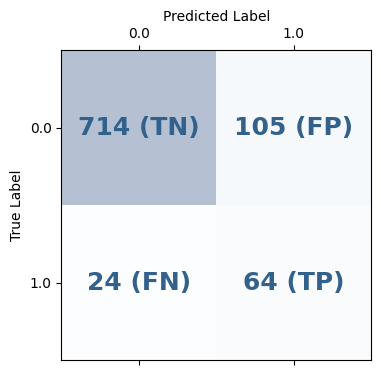

False Positive Rate (FPR): 0.128
Recall: 0.727
Negative Recall: 0.872
Precision: 0.379
F1 Score: 0.498
ROC AUC = 0.7697372072372073
Accuracy = 0.8577728776185226


In [16]:
FPR, Recall, Negative_Recall, Precision, AUC, accuracy = all_results(dtc_pipeline, X_test_call, y_train_call, y_test_call)

Below the feature importances are plotted. We can see that, again, call duration is by far most important feature. Day of month and account balance are also significant. Furthermore, the following months also are significant: february, march, april.

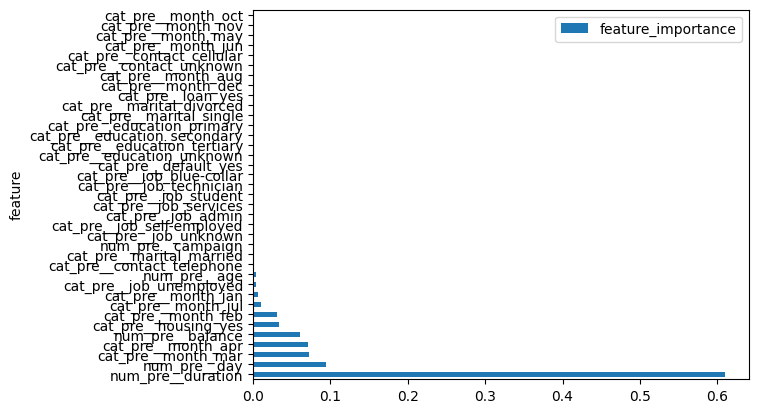

In [43]:
plot_feature_importance(dtc_pipeline[-1], selected_feature_names)

AUC value: 0.7756202131202132


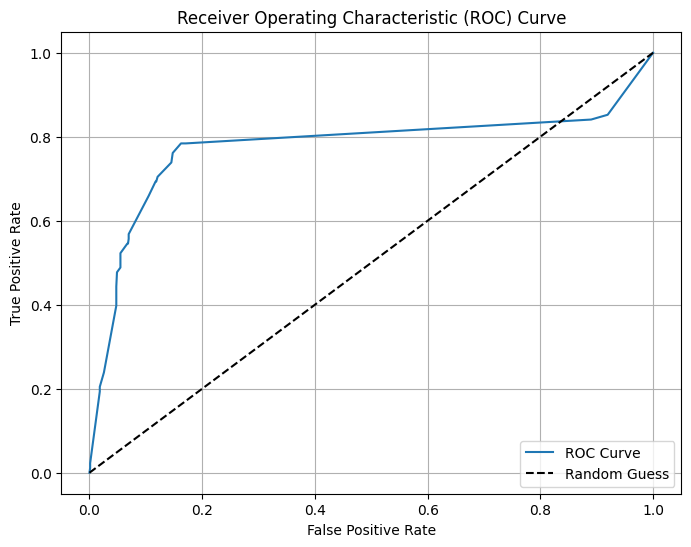

In [46]:
predictions_pa = dtc_pipeline.predict_proba(X_test_call)

roc_calc = roc_curve(y_true = y_test_call, y_score = predictions_pa[:,1])
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)
print("AUC value:", roc_auc_score(y_true = y_test_call, y_score = predictions_pa[:,1]))

# Compute precision-recall curve
baseline_precision, baseline_recall, thresholds = precision_recall_curve(y_test_call, predictions_pa[:,1])

# Compute area under the curve (AUC)
baseline_auc_score = auc(baseline_recall, baseline_precision)

plot_roc_curve(roc)

#### SVC

Below, we implement a baseline SVC model. The model performance scores are displayed below. As we can see, the model classifies almost all datapoints as negative. We therefore need to perform hyperparameter optimization to improve results.

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       819
           1       0.50      0.01      0.02        88

    accuracy                           0.90       907
   macro avg       0.70      0.51      0.49       907
weighted avg       0.86      0.90      0.86       907



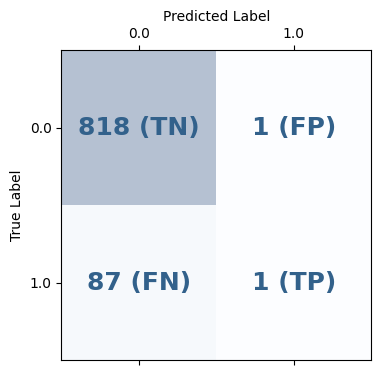

False Positive Rate (FPR): 0.001
Recall: 0.011
Negative Recall: 0.999
Precision: 0.500
F1 Score: 0.022
ROC AUC = 0.8784965034965035
Accuracy = 0.9029768467475193


In [12]:
svc_pipeline = Pipeline(steps=[('model', SVC(probability=True))])
svc_pipeline.fit(X_train_call,y_train_call)
FPR, Recall, Negative_Recall, Precision, AUC, accuracy = all_results(svc_pipeline, X_test_call, y_train_call, y_test_call)


Below, we implement hyperparameter optimization, maximizing for F1 score.

In [17]:
# Define the objective function
def objective(params):
    # the number of features, ensuring it is an integer
    # Set up classifier hyperparameters 
    # Set up classifier hyperparameters: start with C
    dt_params = {
        'C': params['C'],
        'probability' : params['probability']
    }
    
    # Extract the kernel-specific parameters
    kernel_params = params['kernel']
    kernel_type = kernel_params['kernel']
    
    # If poly kernel, cast degree to int and map coef0_poly to coef0
    if kernel_type == 'poly':
        kernel_params['degree'] = int(kernel_params['degree'])
        kernel_params['coef0'] = kernel_params.pop('coef0_poly')
    
    # If sigmoid kernel, map coef0_sigmoid to coef0
    if kernel_type == 'sigmoid':
        kernel_params['coef0'] = kernel_params.pop('coef0_sigmoid')
    
    # Merge the kernel parameters into dt_params
    dt_params.update(kernel_params)


    classifier_final = SVC(max_iter=1000, **dt_params)



    # Create a pipeline that first does feature selection, then classification
    pipeline = Pipeline(steps=[('clf', classifier_final)])
    
    # Use cross-validation to evaluate performance using negative recall
    score = cross_val_score(pipeline, X_train_call, y_train_call, scoring='f1', cv=5).mean()
    
    # Hyperopt minimizes the objective, so return the negative score (to maximize negative recall)
    return {'loss': -score, 'status': STATUS_OK}



# Define the hyperparameter search space using hp.choice for discrete parameters
search_space = {
    'C': hp.loguniform('C', np.log(0.001), np.log(1000)),
    'probability' : hp.choice('probability', [True]),
    'kernel': hp.choice('kernel', [
        {
            'kernel': 'linear'
        },
        {
            'kernel': 'rbf',
            'gamma': hp.loguniform('gamma_rbf', np.log(1e-4), np.log(1e1))
        },
        {
            'kernel': 'poly',
            'gamma': hp.loguniform('gamma_poly', np.log(1e-4), np.log(1e1)),
            'degree': hp.quniform('degree', 2, 5, 1),
            'coef0_poly': hp.uniform('coef0_poly', -1, 1)
        },
        {
            'kernel': 'sigmoid',
            'gamma': hp.loguniform('gamma_sigmoid', np.log(1e-4), np.log(1e1)),
            'coef0_sigmoid': hp.uniform('coef0_sigmoid', -1, 1)
        }

    ])
}


# Run Hyperopt
trials = Trials()
best = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=500,
    trials=trials
)

best_params = space_eval(search_space, best)
print("Best hyperparameters:", best_params)


100%|██████████| 500/500 [18:33<00:00,  2.23s/trial, best loss: -0.5950905432595575]
Best hyperparameters: {'C': 803.2502826515849, 'kernel': {'kernel': 'linear'}, 'probability': True}


The results of the hyperparameter optimised model are given below. As we can see, the model achieves an overall accuracy of 89%, a recall score of 0.477, and F1 score of 0.551.

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       819
           1       0.43      0.48      0.45        88

    accuracy                           0.89       907
   macro avg       0.69      0.71      0.70       907
weighted avg       0.89      0.89      0.89       907



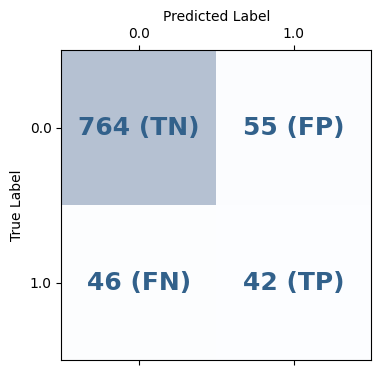

False Positive Rate (FPR): 0.067
Recall: 0.477
Negative Recall: 0.933
Precision: 0.433
F1 Score: 0.454
ROC AUC = 0.8297050172050171
Accuracy = 0.8886438809261301


In [12]:
params = {'C': 91.22234988798179, 'kernel': {'coef0_poly': 0.0573016883662405, 'degree': 3.0, 'gamma': 0.1671014531389079, 'kernel': 'poly'}, 'probability': True}


dt_params = {
        'C': params['C'],
        'probability' : params['probability']
    }
    
# Extract the kernel-specific parameters
kernel_params = params['kernel']
kernel_type = kernel_params['kernel']

# If poly kernel, cast degree to int and map coef0_poly to coef0
if kernel_type == 'poly':
    kernel_params['degree'] = int(kernel_params['degree'])
    kernel_params['coef0'] = kernel_params.pop('coef0_poly')

# If sigmoid kernel, map coef0_sigmoid to coef0
if kernel_type == 'sigmoid':
    kernel_params['coef0'] = kernel_params.pop('coef0_sigmoid')

# Merge the kernel parameters into dt_params
dt_params.update(kernel_params)


classifier_final = SVC(max_iter=1000, **dt_params)

# Create a pipeline that first does feature selection, then classification
pipeline = Pipeline(steps=[('clf', classifier_final)])

pipeline.fit(X_train_call, y_train_call)

FPR, Recall, Negative_Recall, Precision, AUC, accuracy = all_results(pipeline, X_test_call, y_train_call, y_test_call)

##### Logistic Regression

Below, we perform hyperparameter optimization on the logistic regression model, maximising for recall. The point of this exercise is to find a model with high recall, with which to combine the other models we have seen so far in a soft voting model. 

In [19]:
def objective(params):

    n_features = int(params['n_features'])

    log_params = {
        'C': params['C'],
        'class_weight': params['class_weight'],
        'penalty': params['penalty'],
        'random_state': params['random_state'],
        'solver' : params['solver']
    
    }

    if params['penalty'] == 'elasticnet':
        log_params['l1_ratio'] = params['l1_ratio']
    else:
        log_params['l1_ratio'] = None


    # Create an instance for RFE
    classifier_for_rfe = LogisticRegression(**log_params)
    rfe = RFE(estimator=classifier_for_rfe, 
              n_features_to_select=n_features)

    # Create a new instance for the final classifier
    classifier_final = LogisticRegression(**log_params)
    pipeline = Pipeline(steps=[('rfe', rfe), ('clf', classifier_final)])

    # Use cross-validation to evaluate performance using negative recall
    score = cross_val_score(pipeline, X_train_call, y_train_call, scoring='recall', cv=5).mean()
    
    # Hyperopt minimizes the objective, so return the negative score (to maximize negative recall)
    return {'loss': -score, 'status': STATUS_OK}




search_space = {
    'n_features' : hp.choice('n_features', [5,10,15,20,25]), 
    'C': hp.loguniform('C', -5, 25),  
    'class_weight': hp.choice('class_weight', [None, "balanced"]),
    'penalty' : hp.choice('penalty', ['l1', 'l2','elasticnet', None]),
    'l1_ratio': hp.uniform('l1_ratio', 0, 1),
    'random_state' : hp.choice('random_state', [int(seed)]),
    'solver' : hp.choice('solver', ['saga'])
}

trials = Trials()
best = fmin(
    fn = objective,
    space = search_space,
    algo = tpe.suggest,
    max_evals=100,
    trials = trials
)

best_params = space_eval(search_space, best)
print("Best hyperparameters:", best_params)


100%|██████████| 100/100 [26:59<00:00, 16.19s/trial, best loss: -0.827122736418511]
Best hyperparameters: {'C': 3953364.863417549, 'class_weight': 'balanced', 'l1_ratio': 0.8523590351906029, 'n_features': 15, 'penalty': None, 'random_state': 7122, 'solver': 'saga'}


In [42]:
log_params = {'C': 3953364.863417549, 'class_weight': 'balanced', 'l1_ratio': 0.8523590351906029, 'n_features': 15, 'penalty': None, 'random_state': 7122, 'solver': 'saga'}

n_features = int(log_params['n_features'])

del log_params['n_features']

# Create an instance for RFE
classifier_for_rfe = LogisticRegression(**log_params)

rfe = RFE(estimator=classifier_for_rfe, 
              n_features_to_select=n_features)

# Create a new instance for the final classifier
classifier_final = LogisticRegression(**log_params)
log_pipeline = Pipeline(steps=[('rfe', rfe), ('clf', classifier_final)])


log_pipeline.fit(X_train_call,y_train_call)
mask = log_pipeline.named_steps['rfe'].support_
selected_feature_names_log = X_train_call.columns[mask]

print("Selected features:", selected_feature_names_log)


Selected features: Index(['num_pre__balance', 'num_pre__day', 'num_pre__duration',
       'cat_pre__job_housemaid', 'cat_pre__job_unknown',
       'cat_pre__housing_yes', 'cat_pre__contact_unknown',
       'cat_pre__month_aug', 'cat_pre__month_dec', 'cat_pre__month_jan',
       'cat_pre__month_jul', 'cat_pre__month_jun', 'cat_pre__month_mar',
       'cat_pre__month_nov', 'cat_pre__month_oct'],
      dtype='object')


The results of the model are displayed below. As we can see, the model obtains high recall (0.86). Thus, this model will be a useful model to include in a soft-voting model.

              precision    recall  f1-score   support

           0       0.98      0.84      0.91       819
           1       0.37      0.86      0.51        88

    accuracy                           0.84       907
   macro avg       0.67      0.85      0.71       907
weighted avg       0.92      0.84      0.87       907



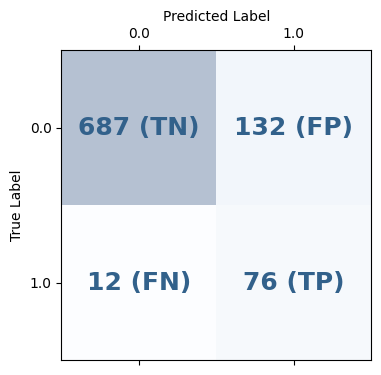

False Positive Rate (FPR): 0.161
Recall: 0.864
Negative Recall: 0.839
Precision: 0.365
F1 Score: 0.514
ROC AUC = 0.9120324120324119
Accuracy = 0.8412348401323043


In [23]:
FPR, Recall, Negative_Recall, Precision, AUC, accuracy = all_results(log_pipeline, X_test_call, y_train_call, y_test_call)


Below we plot the importance of the features in our model. As we can see, the most important features with positive coefficient is day of the month. 

Coefficients of the best logistic regression model:
[ 5.75242345  1.70857243 30.03093038 -2.53343307 -3.46646361 -0.93462804
 -2.61435831 -2.21399264 -2.67354939 -4.80429985 -2.84418703  1.44593682
  2.92053574 -2.51084487  2.07035489]
Intercept of the best logistic regression model:
5.752423449455747


NameError: name 'Patch' is not defined

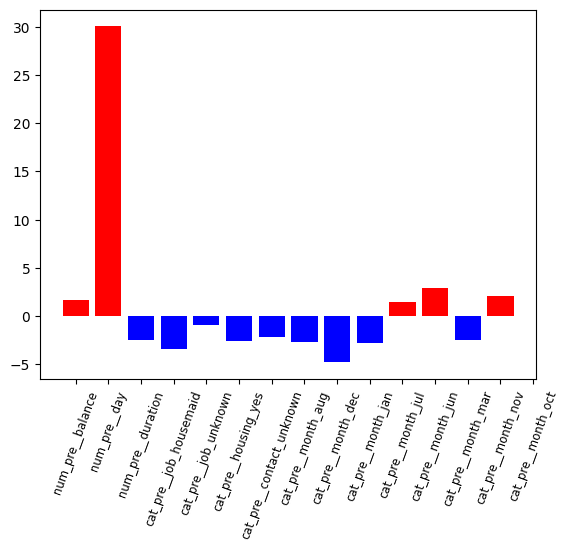

In [43]:
coefficients = log_pipeline.named_steps['clf'].coef_[0]
print("Coefficients of the best logistic regression model:")
print(coefficients)
print('Intercept of the best logistic regression model:')
print(coefficients[0])

plot_coefs(coefficients[1:], selected_feature_names_log, 'Coefficient Values for Features')

#### Soft Voting Model

As a final model attempt, we implement a soft-voting classifier with decision tree model, SVC, logistic regression

In [37]:
## DTC

best_params_dtc = {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': np.int64(6), 'min_samples_leaf': np.int64(6), 'min_samples_split': np.int64(8), 'n_features': np.int64(10), 'random_state': 7122}
n_features_dtc = int(best_params_dtc['n_features'])
del best_params_dtc['n_features']



classifier_for_rfe = DecisionTreeClassifier(**best_params_dtc)
    
# Set up the RFE with the classifier as the estimator
rfe = RFE(estimator=classifier_for_rfe, n_features_to_select=n_features_dtc)

# Create a pipeline that first does feature selection, then classification
dtc_pipeline = Pipeline(steps=[('rfe', rfe), ('clf', DecisionTreeClassifier(**best_params_dtc))])

params = {'C': 91.22234988798179, 'kernel': {'coef0_poly': 0.0573016883662405, 'degree': 3.0, 'gamma': 0.1671014531389079, 'kernel': 'poly'}, 'probability': True}


### SVC
dt_params = {
        'C': params['C'],
        'probability' : params['probability']
    }
    
# Extract the kernel-specific parameters
kernel_params = params['kernel']
kernel_type = kernel_params['kernel']

# If poly kernel, cast degree to int and map coef0_poly to coef0
if kernel_type == 'poly':
    kernel_params['degree'] = int(kernel_params['degree'])
    kernel_params['coef0'] = kernel_params.pop('coef0_poly')

# If sigmoid kernel, map coef0_sigmoid to coef0
if kernel_type == 'sigmoid':
    kernel_params['coef0'] = kernel_params.pop('coef0_sigmoid')

# Merge the kernel parameters into dt_params
dt_params.update(kernel_params)


classifier_final = SVC(max_iter=1000, **dt_params)

# Create a pipeline that first does feature selection, then classification
svc_pipeline = Pipeline(steps=[('clf', classifier_final)])




### Logistic Regression

log_params = {'C': 2.5624013340251084, 'class_weight': 'balanced', 'l1_ratio': 0.7050230011920622, 'n_features': 5, 'penalty': 'elasticnet', 'random_state': 7122, 'solver': 'saga'}
n_features_log = int(log_params['n_features'])
del log_params['n_features']

# Create an instance for RFE
classifier_for_rfe_log = LogisticRegression(**log_params)

rfe = RFE(estimator=classifier_for_rfe_log, 
              n_features_to_select=n_features_log)

log_pipeline = Pipeline(steps=[('rfe', rfe), ('clf', LogisticRegression(**log_params))])




estimators = [('dtc',dtc_pipeline),('log',log_pipeline), ('svc', svc_pipeline)]

In [38]:
vote_clf = VotingClassifier(
    estimators=estimators, voting='soft'
)

vote_clf.fit(X_train_call, y_train_call)

VotingClassifier(estimators=[('dtc',
                              Pipeline(steps=[('rfe',
                                               RFE(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                    max_depth=np.int64(6),
                                                                                    min_samples_leaf=np.int64(6),
                                                                                    min_samples_split=np.int64(8),
                                                                                    random_state=7122),
                                                   n_features_to_select=10)),
                                              ('clf',
                                               DecisionTreeClassifier(class_weight='balanced',
                                                                      max_depth=np.int64(6),
                                                                      min_samples_leaf=np.int64(6)...
                                                   n_features_to_select=5)),
                                              ('clf',
                                               LogisticRegression(C=2.5624013340251084,
                                                                  class_weight='balanced',
                                                                  l1_ratio=0.7050230011920622,
                                                                  penalty='elasticnet',
                                                                  random_state=7122,
                                                                  solver='saga'))])),
                             ('svc',
                              Pipeline(steps=[('clf',
                                               SVC(C=91.22234988798179,
                                                   coef0=0.0573016883662405,
                                                   gamma=0.1671014531389079,
                                                   kernel='poly', max_iter=1000,
                                                   probability=True))]))],
                 voting='soft')

The results are given below. As we can see, this soft voting model takes advantage of relative strengths of all three models, to yield a model with accuracy of 89%, recall of 0.705 and F1 score of 0.549. We will use this model as our final model for this section.

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       819
           1       0.45      0.70      0.55        88

    accuracy                           0.89       907
   macro avg       0.71      0.81      0.74       907
weighted avg       0.92      0.89      0.90       907



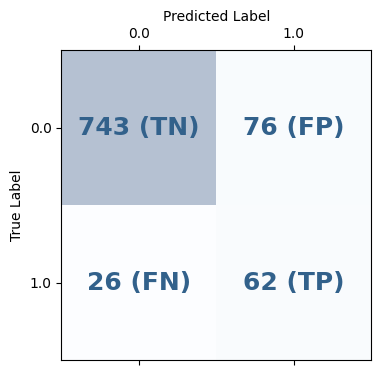

False Positive Rate (FPR): 0.093
Recall: 0.705
Negative Recall: 0.907
Precision: 0.449
F1 Score: 0.549
ROC AUC = 0.8982545232545234
Accuracy = 0.8875413450937155


In [40]:
FPR, Recall, Negative_Recall, Precision, AUC, accuracy = all_results(vote_clf, X_test_call, y_train_call, y_test_call)

##### Analysis of Results for Call Model

In this section, we have worked with three models. We then combined these three models into a soft voting ensemble model, which yielded desired results. Furthermore, through our analysis of the feature importance in the models, we were able to come up with these two general rules of thumb for our callers.

1. Call length is most indicative of whether or not a customer will subscribe. We realise that callers may not have control over this, as some customers may choose to hang up quickly. However, we recommend trying to talk for as long as possible.
2. Call customers later in the month, as they are more likely to subscribe then.

## Subscriber Base Unsupervised Learning Model

To analyse our subscribe base, we will use an unsupervised K-means++ clustering model. The goal of this exercise is to understand the main groups that form our subsriber base. We do this in order to understand who are subscribers are, in order to gauge which demographic our callers should target. Therefore, we can view this section as an extension or accompaniment to our Customers Model we designed at the beginning of the project.

Below, we prepare our dataset for clustering.

In [159]:
df = pd.read_csv("term-deposit-marketing-2020.csv")
X = df.drop(["y"], axis = 1) # defining feature matrix
features = X.columns.to_list() # creating list of features
y = df['y'] # defining target variable

enc = OneHotEncoder(drop='if_binary')

y = y.values
y = y.reshape(-1,1)
enc.fit(y)
y = enc.transform(y).toarray()



In [160]:
X_cluster = X.loc[y == 1]



In [ ]:
features_to_remove = ["day", 'month','duration','campaign']
X_cluster = X_cluster.drop(features_to_remove, axis = 1)

In [164]:
features = X_cluster.columns.to_list()

In [165]:
# numerical features to standardize (using min_max scaler)
num = ['age', 'balance',]
num_i = [0, 5]

# categorical features to one-hot-encode
cat = ['job', 'marital', 'education', 'default','housing','loan','contact']
cat_i = [1, 2, 3, 4, 6, 7, 8]

In [166]:
set_config(display='diagram')

# numerical features preprocessing
num_pre = Pipeline([
    ("num_scale", MinMaxScaler()),
])

# categorical features preprocessing
cat_pre = Pipeline([
    ("cat_encode", OneHotEncoder(drop='if_binary', sparse_output =False))
])

Preprocessor = Pipeline([
    ("pre_processing", ColumnTransformer([
        ("num_pre", num_pre, num_i), # Applied to the numerical variables
        ("cat_pre", cat_pre, cat_i)
        ])), # Applied to the nominal variables 
])
display(Preprocessor)

Pipeline(steps=[('pre_processing',
                 ColumnTransformer(transformers=[('num_pre',
                                                  Pipeline(steps=[('num_scale',
                                                                   MinMaxScaler())]),
                                                  [0, 5]),
                                                 ('cat_pre',
                                                  Pipeline(steps=[('cat_encode',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  [1, 2, 3, 4, 6, 7, 8])]))])

In [167]:
X_cluster = Preprocessor.fit_transform(X_cluster)
pd.DataFrame(X_cluster).info(verbose=False)
feature_names = Preprocessor.named_steps["pre_processing"].get_feature_names_out(input_features=features)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Columns: 27 entries, 0 to 26
dtypes: float64(27)
memory usage: 611.0 KB


In [169]:
X_cluster_pd = pd.DataFrame(X_cluster,columns = feature_names)


Below, we calculate the within cluster variation (WCV) as a function of number of clusters, and plot it. We can see that WCV decreases steadily with number of clusters, as expected. As always with clustering, choosing number of clusters is a non-trivial task. However, from the graph, we can see that the marginal decrease in WCV per increase in cluster number appears to decrease intensely from 6 to 7 clusters. Therefore 6 clusters seems a reasonable choice.

In [171]:
K = np.arange(1,100)
WCV = np.zeros(K.shape)

for i in range(K.shape[0]):
    kmeans_K = KMeans(n_clusters = K[i], n_init = 20, random_state=seed).fit(X_cluster_pd)
    WCV[i] = kmeans_K.inertia_

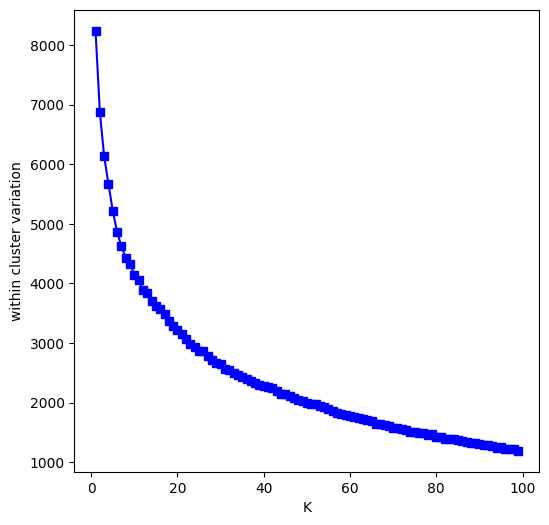

In [172]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.plot(K, WCV, c='b',marker='s')
plt.xlabel('K')
plt.ylabel('within cluster variation')
plt.show()

Below, we plot the means of all 6 of our clusters, in order to understand the main 6 groups in our subscribers base.

In [262]:
n_clusters_to_choose = 6
kmeans_test = KMeans(n_clusters = n_clusters_to_choose, n_init = 20, random_state=seed).fit(X_cluster_pd)

cluster_centres = kmeans_test.cluster_centers_

In [ ]:
fitted_scaler = Preprocessor.named_steps['pre_processing'].named_transformers_['num_pre'].named_steps['num_scale']
numerical_centres = cluster_centres[:,:2]
numerical_centres_original = fitted_scaler.inverse_transform(numerical_centres)

age, bank account
[  46.04878049 1398.84823848]


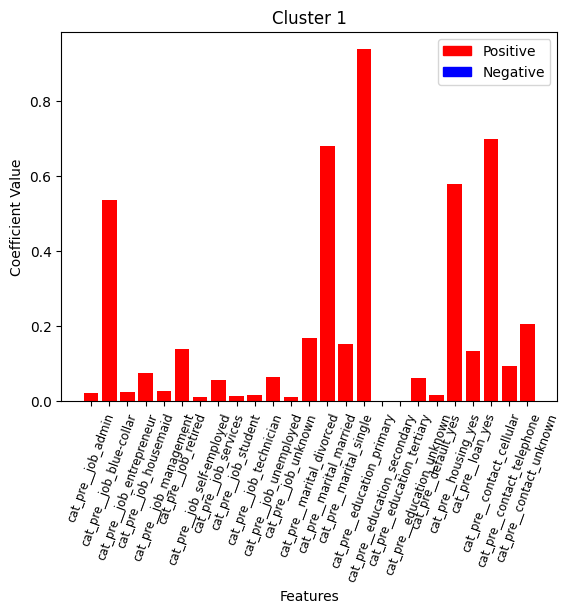

age, bank account
[  32.91777778 2192.54      ]


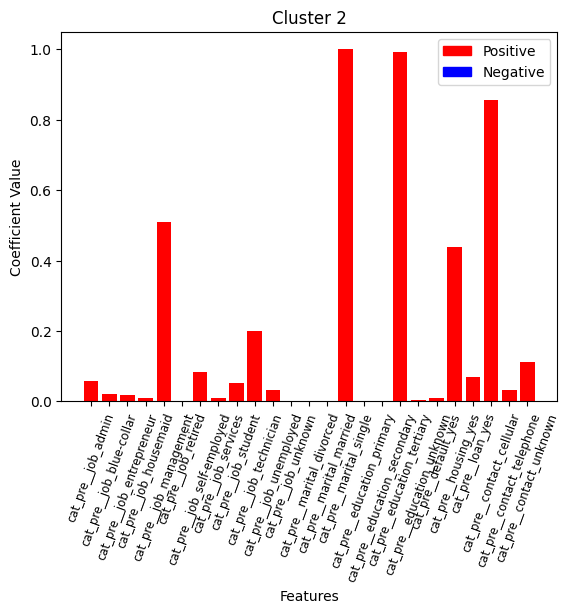

age, bank account
[  42.46305419 1668.65845649]


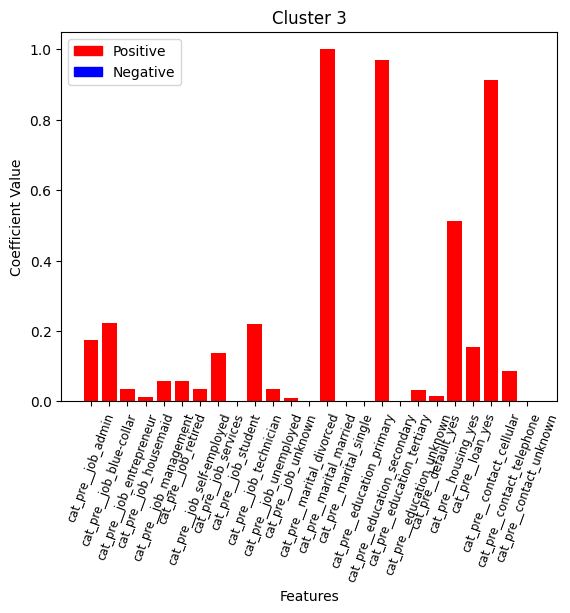

age, bank account
[  43.23263889 1773.62673611]


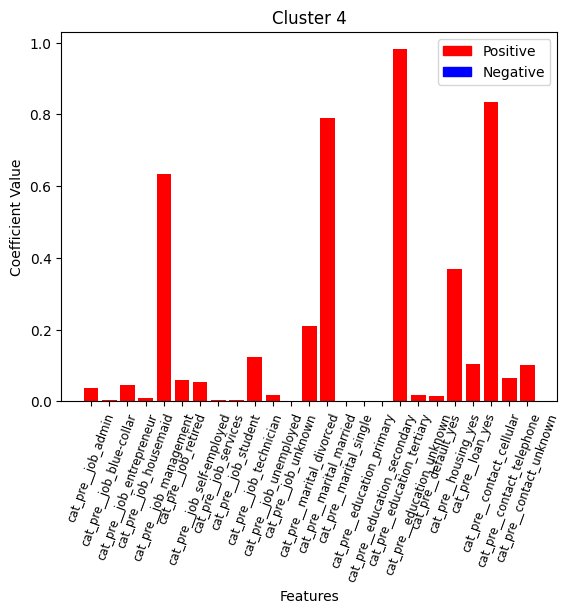

age, bank account
[  38.85987261 1267.28343949]


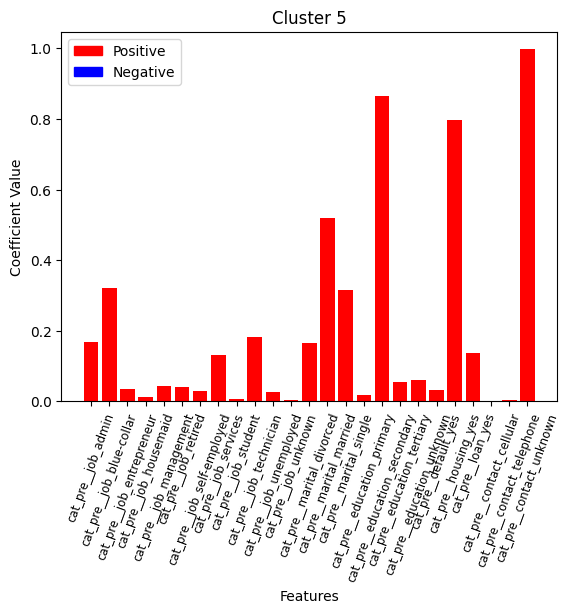

age, bank account
[  35.67820069 1144.83910035]


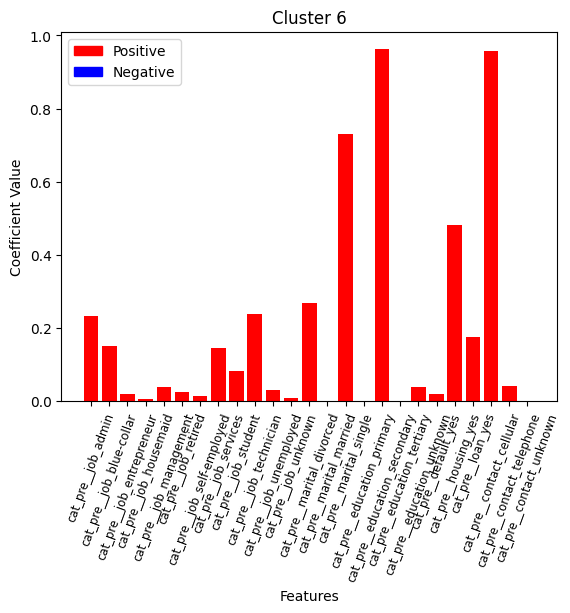

In [269]:
for i in range(n_clusters_to_choose):
    print('age, bank account')
    print(numerical_centres_original[i])
    plot_coefs(cluster_centres[i,2:],feature_names[2:],'Cluster '+str(int(i+1)))

Above, we have plotted the centres of the 6 clusters obtained with k-means clustering. We chose 6 clusters, as we noticed the plot of intercluster variation seemed to settle around 6 clusters. There are interesting things to note. We have summarised the 6 clusters below.

Cluster 1: Older demographic, with low amount money in their bank account, who are mostly married, with a housing loan loan, with only primary education.

Cluster 2: Younger demographic, with high amount money, who are mostly single, have tertiary education, and work in management. 

Cluster 3: Middle aged demographic, with medium amount of money, mostly married, with secondary education, working a variety of jobs. Half have a housing loan.

Cluster 4: Middle aged demographic, with mid-high amount of money, mostly married, working mostly in management, with tertiary education.

Cluster 5: Middle aged demographic, with low amount of money, with secondary education and with a housing loan. Half of them are married.

Cluster 6: Younger demographic, with low amount of money, with secondary education, mostly single, half of whom have a housing loan.

We immediately note the similarities between clusters 2 and 4. 



#### Analysis of Subscribers Model

Above, we have noted the main 6 clusters in our subscribers base. As anticipated by our Customers Model, which indicated that a individuals who were older and richer were more likely to subscribe, we found that most of our clusters contained individuals who were 40+ years old. However, it is worth mentioning that 2 of our clusters consisted of individuals who tended to be in their early 30s, with large amounts of money, and who had tertiary education. Therefore, this clustering exercise has shed light on an important target demographic for the call company: a fairly young, highly-educated, and financially stable demographic who are looking to make profitable investments. Furthermore, another of our clusters consisted of a younger demographic, without much money nor education (secondary). Finally, the other demographics consisting of individuals who were 40+ years old, and who mostly had secondary education.

It has been interesting to go through both this clustering exercise, and the Customers Model from before. In the Customers Model, we found that older individuals with more money were generally more likely to subscribe. However, in this clustering exercise, we were made aware of two important subscriber demographics: young, married people, with lots of money, tertiary education, and young, single people, with little money, secondary education. Therefore, this exercise has been useful, as we can therefore recommend to our callers that, altough they should generally target individuals who are older and have more money, it is also worth considering younger individuals with lots of money, tertiary education, who may also be keen to make this investment. 

## Conclusion and Analysis

This project has consisted of three sections: a Customer Model, a Call Model, and an analysis of our subscriber base using an unsupervised model. 

#### Customer Model

The goal of the Customer Model was to identify whether or not an individual will subscribe to our product, without knowing any information related to the subscription advertising campaign. In other words, we created a model, which only took as features the features describing the individuals characteristics (age, bank account balance, profession, etc), and ignored other features in the dataset (such as length of calls, number of calls, when calls were placed etc). The point of the first model is to save the calling company the expenses of calling individuals who are unlikely to subscribe. This is an issue for this company, as only 7.2% of all individuals the company calls end up subscribing. Therefore, in this model, we attempt to identify individuals who are highly unlikely to subscribe, so that the call company can choose not to call them, and thus save on expenses. The goal of this model was to eliminate as many negative cases as possible from the test dataset, while avoiding to accidentally eliminate any positive cases. For this reason, we obtained our model by maximizing for recall in hyperparameter optimization. We experimented with a number of classification models and found that decision tree model appeared to work the best.

The Customer Model we created, for a dataset consisting of 8000 datapoints, we managed to successfully eliminate 3300 negative individuals, while accidentally eliminating 24% of individuals who would subscribe (roughly 138 individuals out of a total of 579 individuals). It is up to the company's discretion whether or not to use our model. However, it is highly likely that the savings cost related to not calling 3300 individuals outweigh the revenue from the 138 would-be subscribers. 

Furthermore, through analysis of feature importance in our main model, and other models we experimented with, we found that the age and bank account features were the most indicative of whether an individual would subscribe or not. Therefore, in addition to our model, we are able to offer this general rule of thumb to our callers: older, richer individuals are more likely to subscribe. 

#### Call Model

Using the remaining test dataset after filtering through the Customer Model, we created a Call Model. Again, the goal of this model was to identify whether or not an individual will subscribe to our product. However, this time, we made use of all the features in the dataset. Therefore, the point of this model is to understand the relationship between all features, including those related to the subscription advertising campaign such as length of calls, number of calls, when calls were placed etc, and our target binary variable. As our dataset was still imbalanced, we needed to create a model with high overall accuracy and recall. We ended up creating a model consisting of a ensemble soft voting classifier. The classifier took as estimators a decision tree model, a logistic regression model and an SVC model. Our final voting classifier model had an overall test accuracy of 89% and recall score of 0.705. Therefore, our model achieved a good balance between prioritising subscribers correctly, and maintaining an overall high accuracy.

Through analysis of feature importance in our main model, and other models we experiment with, we found that call length was by far the most important feature in the model (more than bank account balance and age). We therefore recommend to our callers that they try to talk for as long as possible. We realise that callers may not have control over this, as some customers may choose ot hang up quickly. Furthermore, we found that day of the month was also an important feature. Therefore, customers called on a later day in a given month are more likely to subscribe. We therefore recommended to our callers to call their customers later in the month.


#### Subscriber Base Unsupervised Learning Model

To analyse our subscribers base, we used an unsupervised K-means++ clustering model. The goal of this exercise was to better understand the main groups that form our subscribers base. Furthermore, this allows us to gauge which demographic our callers should target. Therefore, we can view this section as an extension or accomponiment to our Customers Model. Through this exercise, we identified several clusters, which consisted of older individuals with a fair amount of money, which agreed with our general findings in our Customers Model. However, we also identified two other clusters, consisting of a generally younger demographic. One of these clusters consisted of a wealthy, highly educated and generally married demographic, and the other consisted of a less wealthy, less educated, single demographic. Therefore, this exercise has been useful, as we can therefore recommend to our callers that, altough they should generally target individuals who are older and have more money, it is also worth considering younger individuals with lots of money, tertiary education, who may also be keen to make this investment. 